In [2]:
# Some standard import statements that are nice for Jupyter

import sys
import os
import logging

import numpy as np

from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

import time

import json

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# importing my model functions for analysis
from psi_transmission.model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Storage Lifetime

We anticipate that pre-storage lifetime measurements should be largely unaffected by changing the installed guide. The total counts may change, but the decay constant $\tau$ should agree from configuration to configuration. This notebook will be broken up by configuration, with lifetime measurements calculated for each set up.

## Normalization Configuration

The relevant runs are:

Run #'s                      | Day |  Storage Time (s)   | Configuration          |
---                          | --- |      ---            | ---                    |
 22 - 24                     | 8   |       20            | normalization          |
 25 - 31                     | 8   |      100            | normalization          |
 32 - 35                     | 8   |        5            | normalization          |
 77 - 79                     | 8   |        5            | normalization          |
 80 - 82                     | 8   |       20            | normalization          |
 83 - 88                     | 8   |      100            | normalization          |
121 - 123                    | 9   |        5            | normalization          |
124 - 125                    | 9   |       20            | normalization          |
      127                    | 9   |       20            | normalization          |
128 - 135                    | 9   |      100            | normalization          |
176 - 183                    | 9   |      100            | normalization          |
184 - 186                    | 9   |       20            | normalization          |
187 - 189                    | 9   |        5            | normalization          |
123 - 130                    | 10  |      100            | normalization          |
131 - 133                    | 10  |       20            | normalization          |
134 - 136                    | 10  |        5            | normalization          |
171 - 179                    | 10  |      100            | normalization          |
180 - 182                    | 10  |       20            | normalization          |
183 - 185                    | 10  |        5            | normalization          |
250 - 252                    | 10  |        5            | normalization          |
253 - 255                    | 10  |       20            | normalization          |
256 - 265                    | 10  |      100            | normalization          |

After applying the source performance normalization to all of these runs, they can be plotted with respect to their storage times.

In [18]:
# fit function for the exponential decay of counts with storage time
def storage_lt_fit(t, N_0, tau):
    return N_0 * np.exp(-t / tau)

In [41]:
def storage_lifetime(data_list):
    
    # initialize an array to hold the run averages
    storage_results = np.zeros((3,3))
    
    for i in range(0, len(data_list)):
    
        # plot all of the runs together
        plt.errorbar(data_list[i][:,1], data_list[i][:,2], yerr = data_list[i][:,3], fmt = '.', label = '{} s'.format(data_list[i][0,1]))
        
        # compute the standard mean
        storage_results[i,0] = data_list[i][0,1]
        storage_results[i,1] = np.mean(data_list[i][:,2])
        storage_results[i,2] = np.std(data_list[i][:,2])
        
    plt.yscale('log')
    plt.ylabel('UCN Counts');
    plt.xlabel('Storage time [s]')
    plt.legend();
    plt.show()
    
    plt.clf()
    popt, pcov = curve_fit(storage_lt_fit, storage_results[:,0], storage_results[:,1], sigma = storage_results[:,2], p0=[150000, 100], absolute_sigma = True)
    plt.plot(np.linspace(0,100,1000), storage_lt_fit(np.linspace(0,100,1000), *popt));
    plt.errorbar(storage_results[:,0], storage_results[:,1], yerr = storage_results[:,2], fmt = '.')
    plt.ylabel('UCN Counts');
    plt.xlabel('Storage time [s]');
    plt.show()
    plt.clf()
    
    # plotting again with log scale
    plt.plot(np.linspace(0,100,1000), storage_lt_fit(np.linspace(0,100,1000), *popt));
    plt.errorbar(storage_results[:,0], storage_results[:,1], yerr = storage_results[:,2], fmt = '.')
    plt.ylabel('UCN Counts');
    plt.xlabel('Storage time [s]');
    plt.yscale('log')
    
    # printing the fit parameters and their errors:
    fit_parameters = np.zeros(np.shape(pcov))
    for i in range(0, np.size(popt)):
        fit_parameters[i,0] = popt[i]
        fit_parameters[i,1] = np.sqrt(np.diag(pcov))[i]
    print("Fit parameters:\n N_0 = {} +/- {},\n TAU: {} +/- {}".format(
            fit_parameters[0,0],
            fit_parameters[0,1],
            fit_parameters[1,0],
            fit_parameters[1,1]))

    chi_sq_over_dof = np.sum(((storage_results[:,1] - storage_lt_fit(storage_results[:,0], 
                                                                     *popt)) 
                              / storage_results[:,2])**2) / (np.shape(storage_results)[0] - len(popt))
    
    print("chi_sq / dof = {}".format(chi_sq_over_dof))

    
    return storage_results

In [22]:
# load data for different storage times
norm_data_5    = load_data_2('NORM', 's005', normalize_flag = True)
norm_data_20   = load_data_2('NORM', 's020', normalize_flag = True)
norm_data_100  = load_data_2('NORM', 's100', normalize_flag = True)
norm_data_list = [norm_data_5, norm_data_20, norm_data_100]

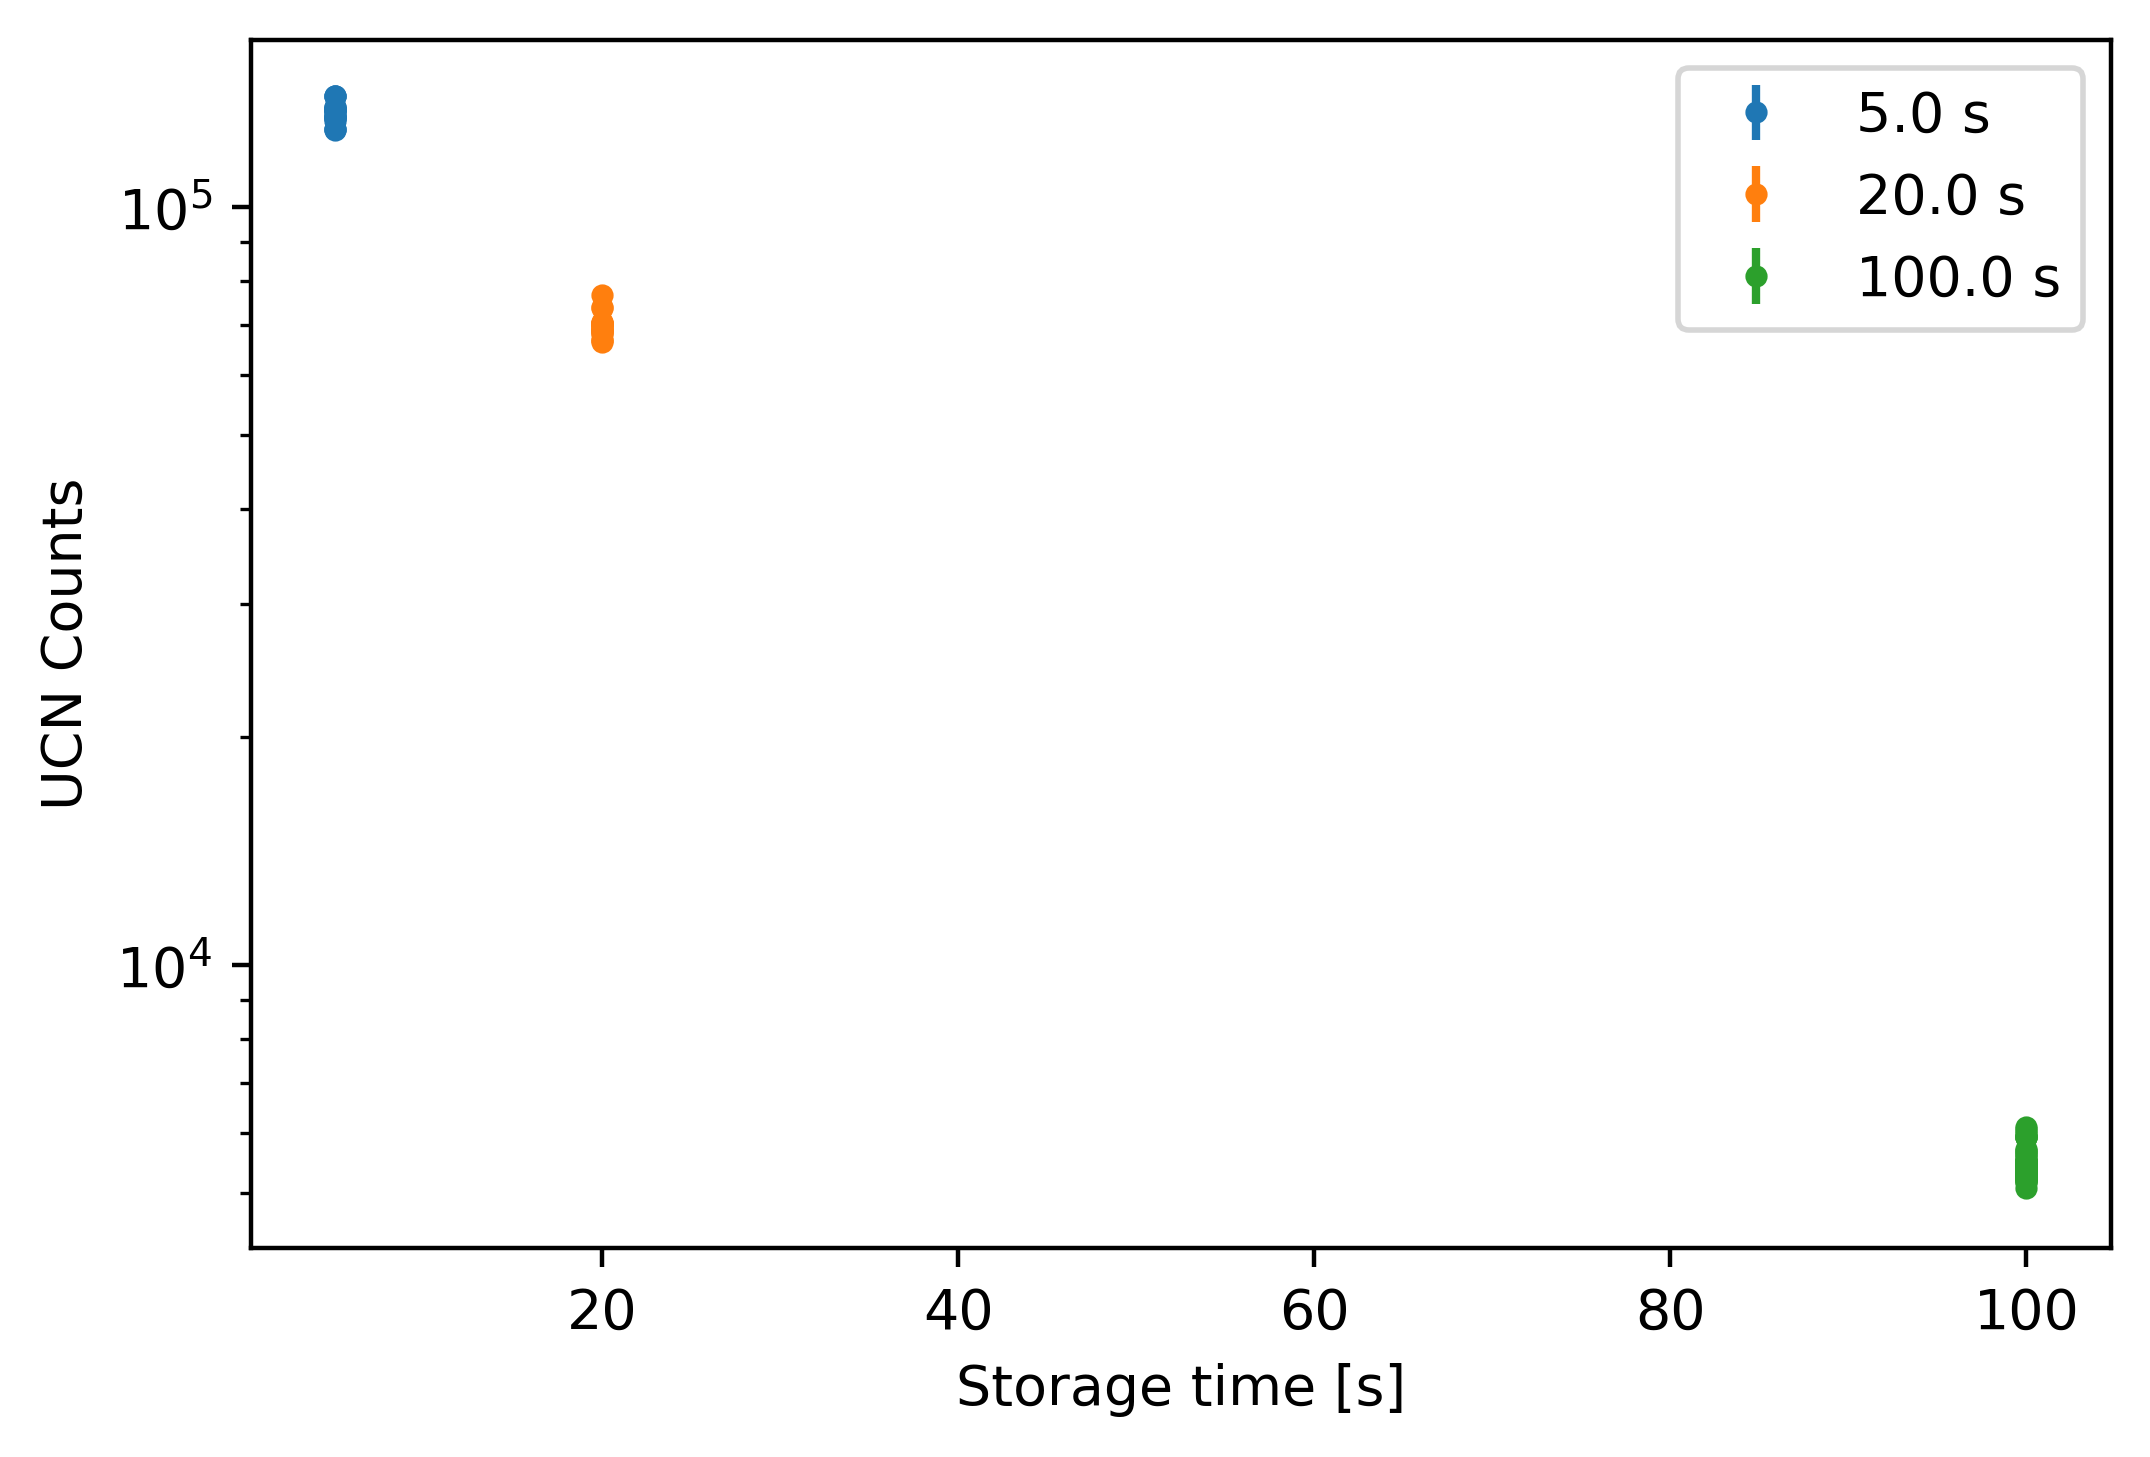

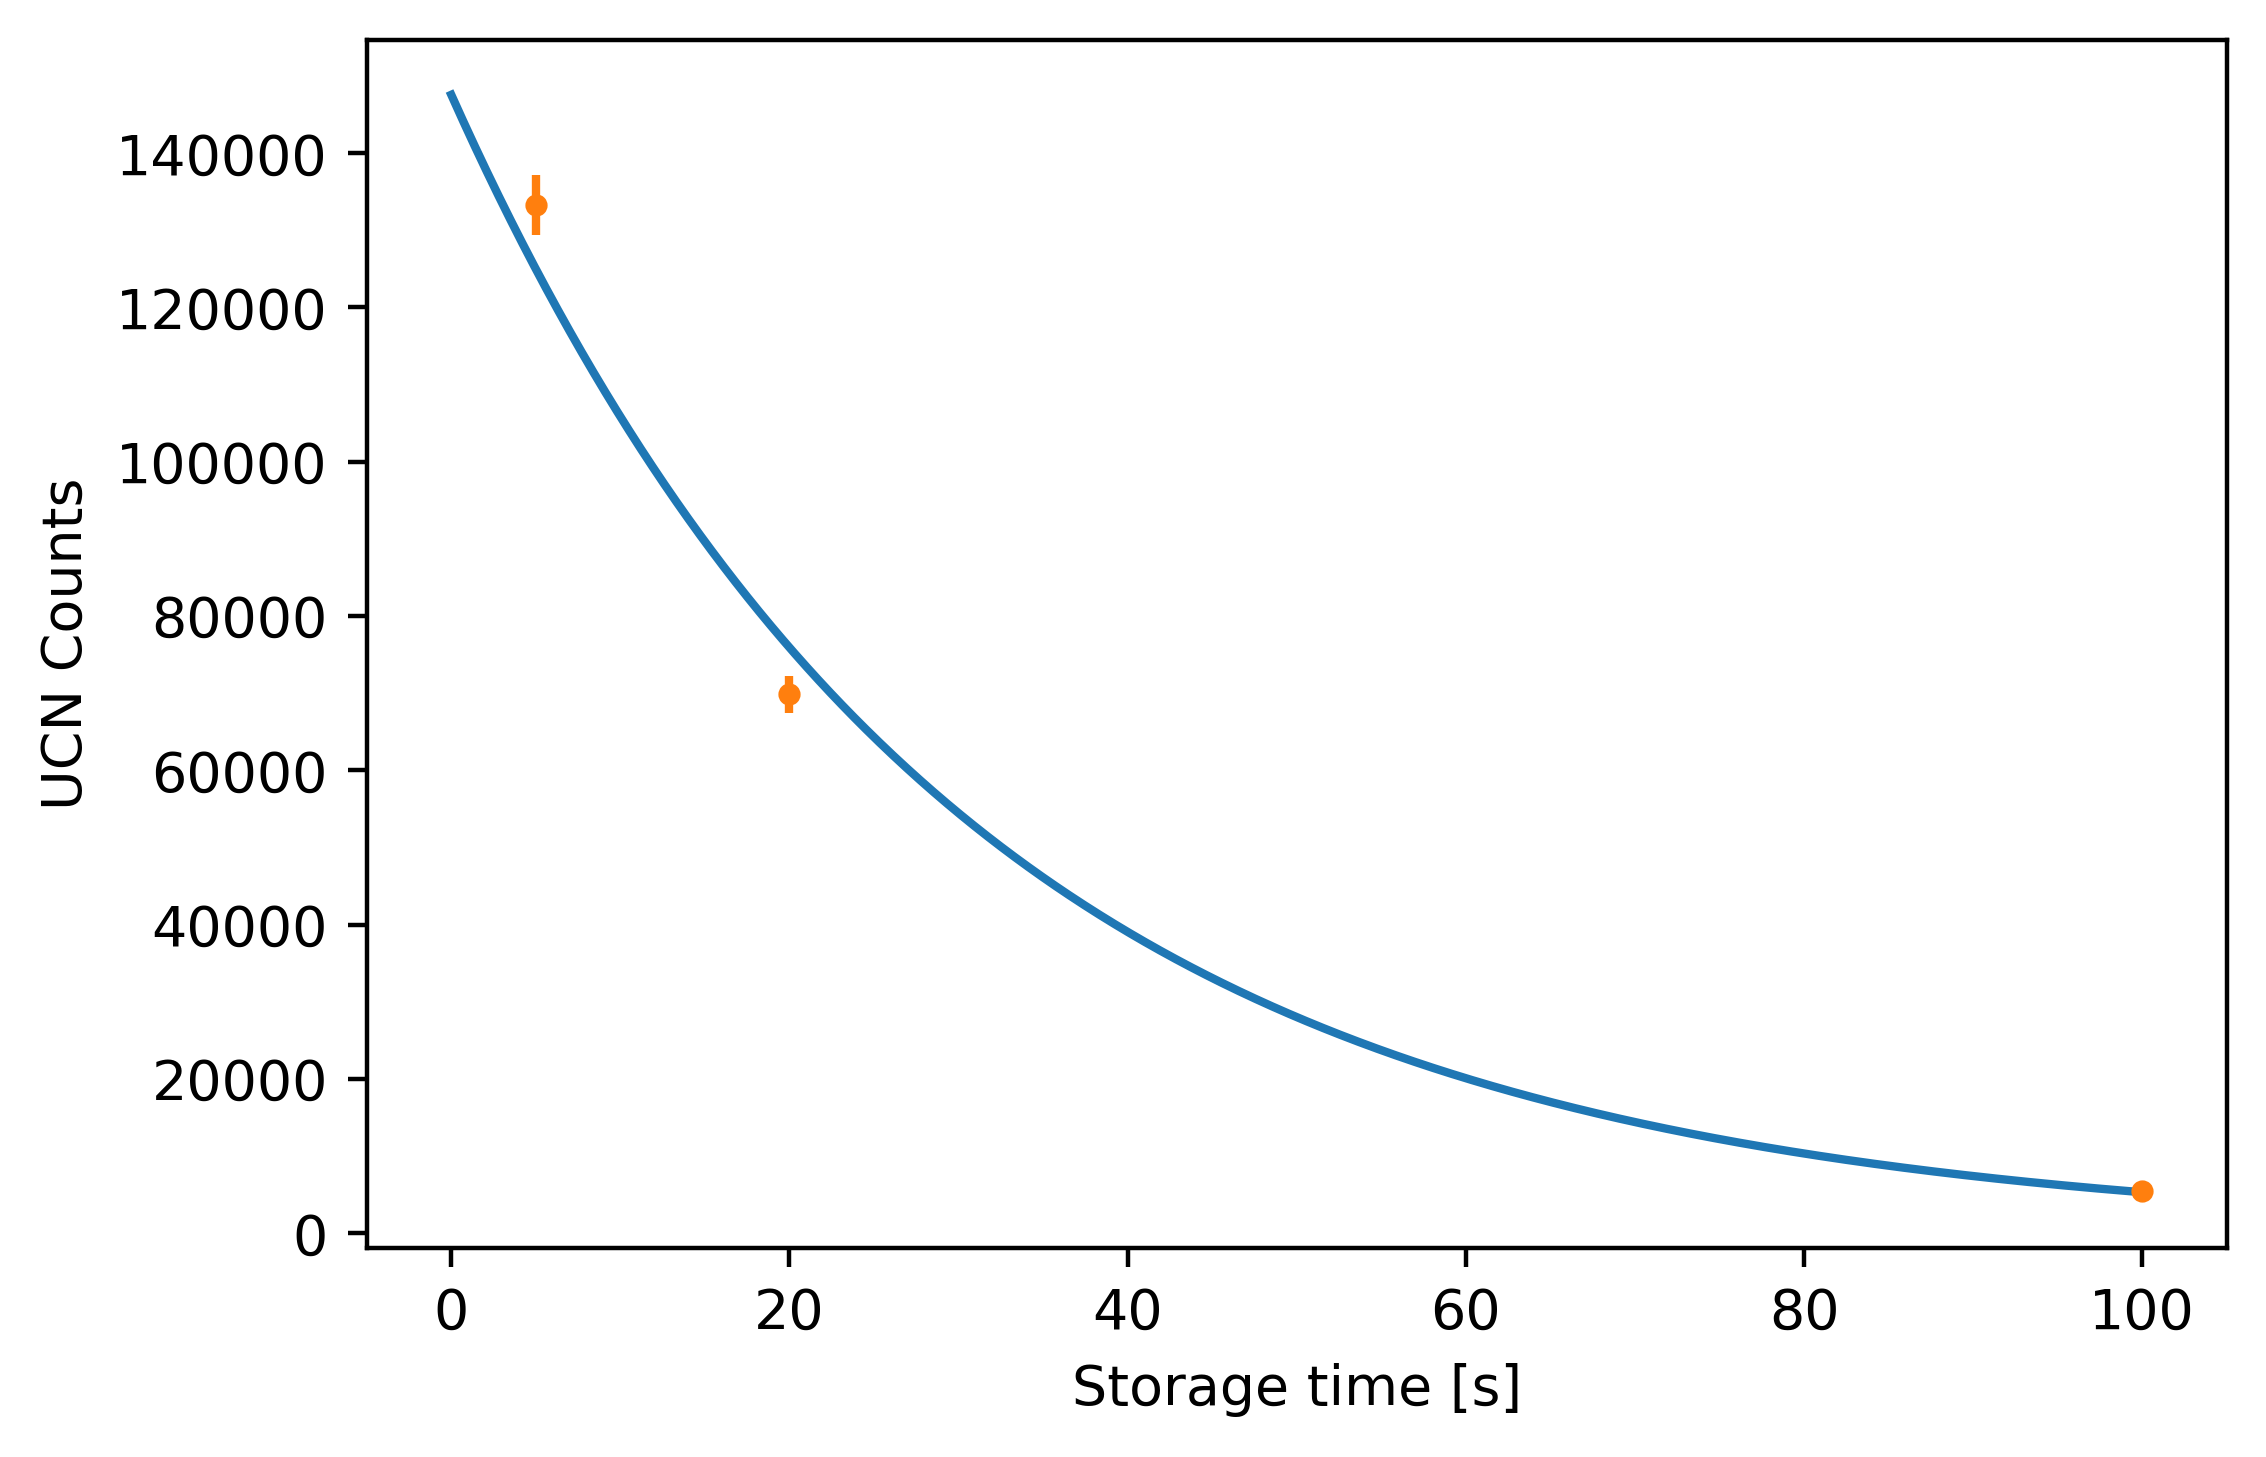

Fit parameters:
 N_0 = 147568.01400414368 +/- 3801.925962855552,
 TAU: 30.096574985880114 +/- 0.5306710129842636
chi_sq / dof = 11.627416318387038


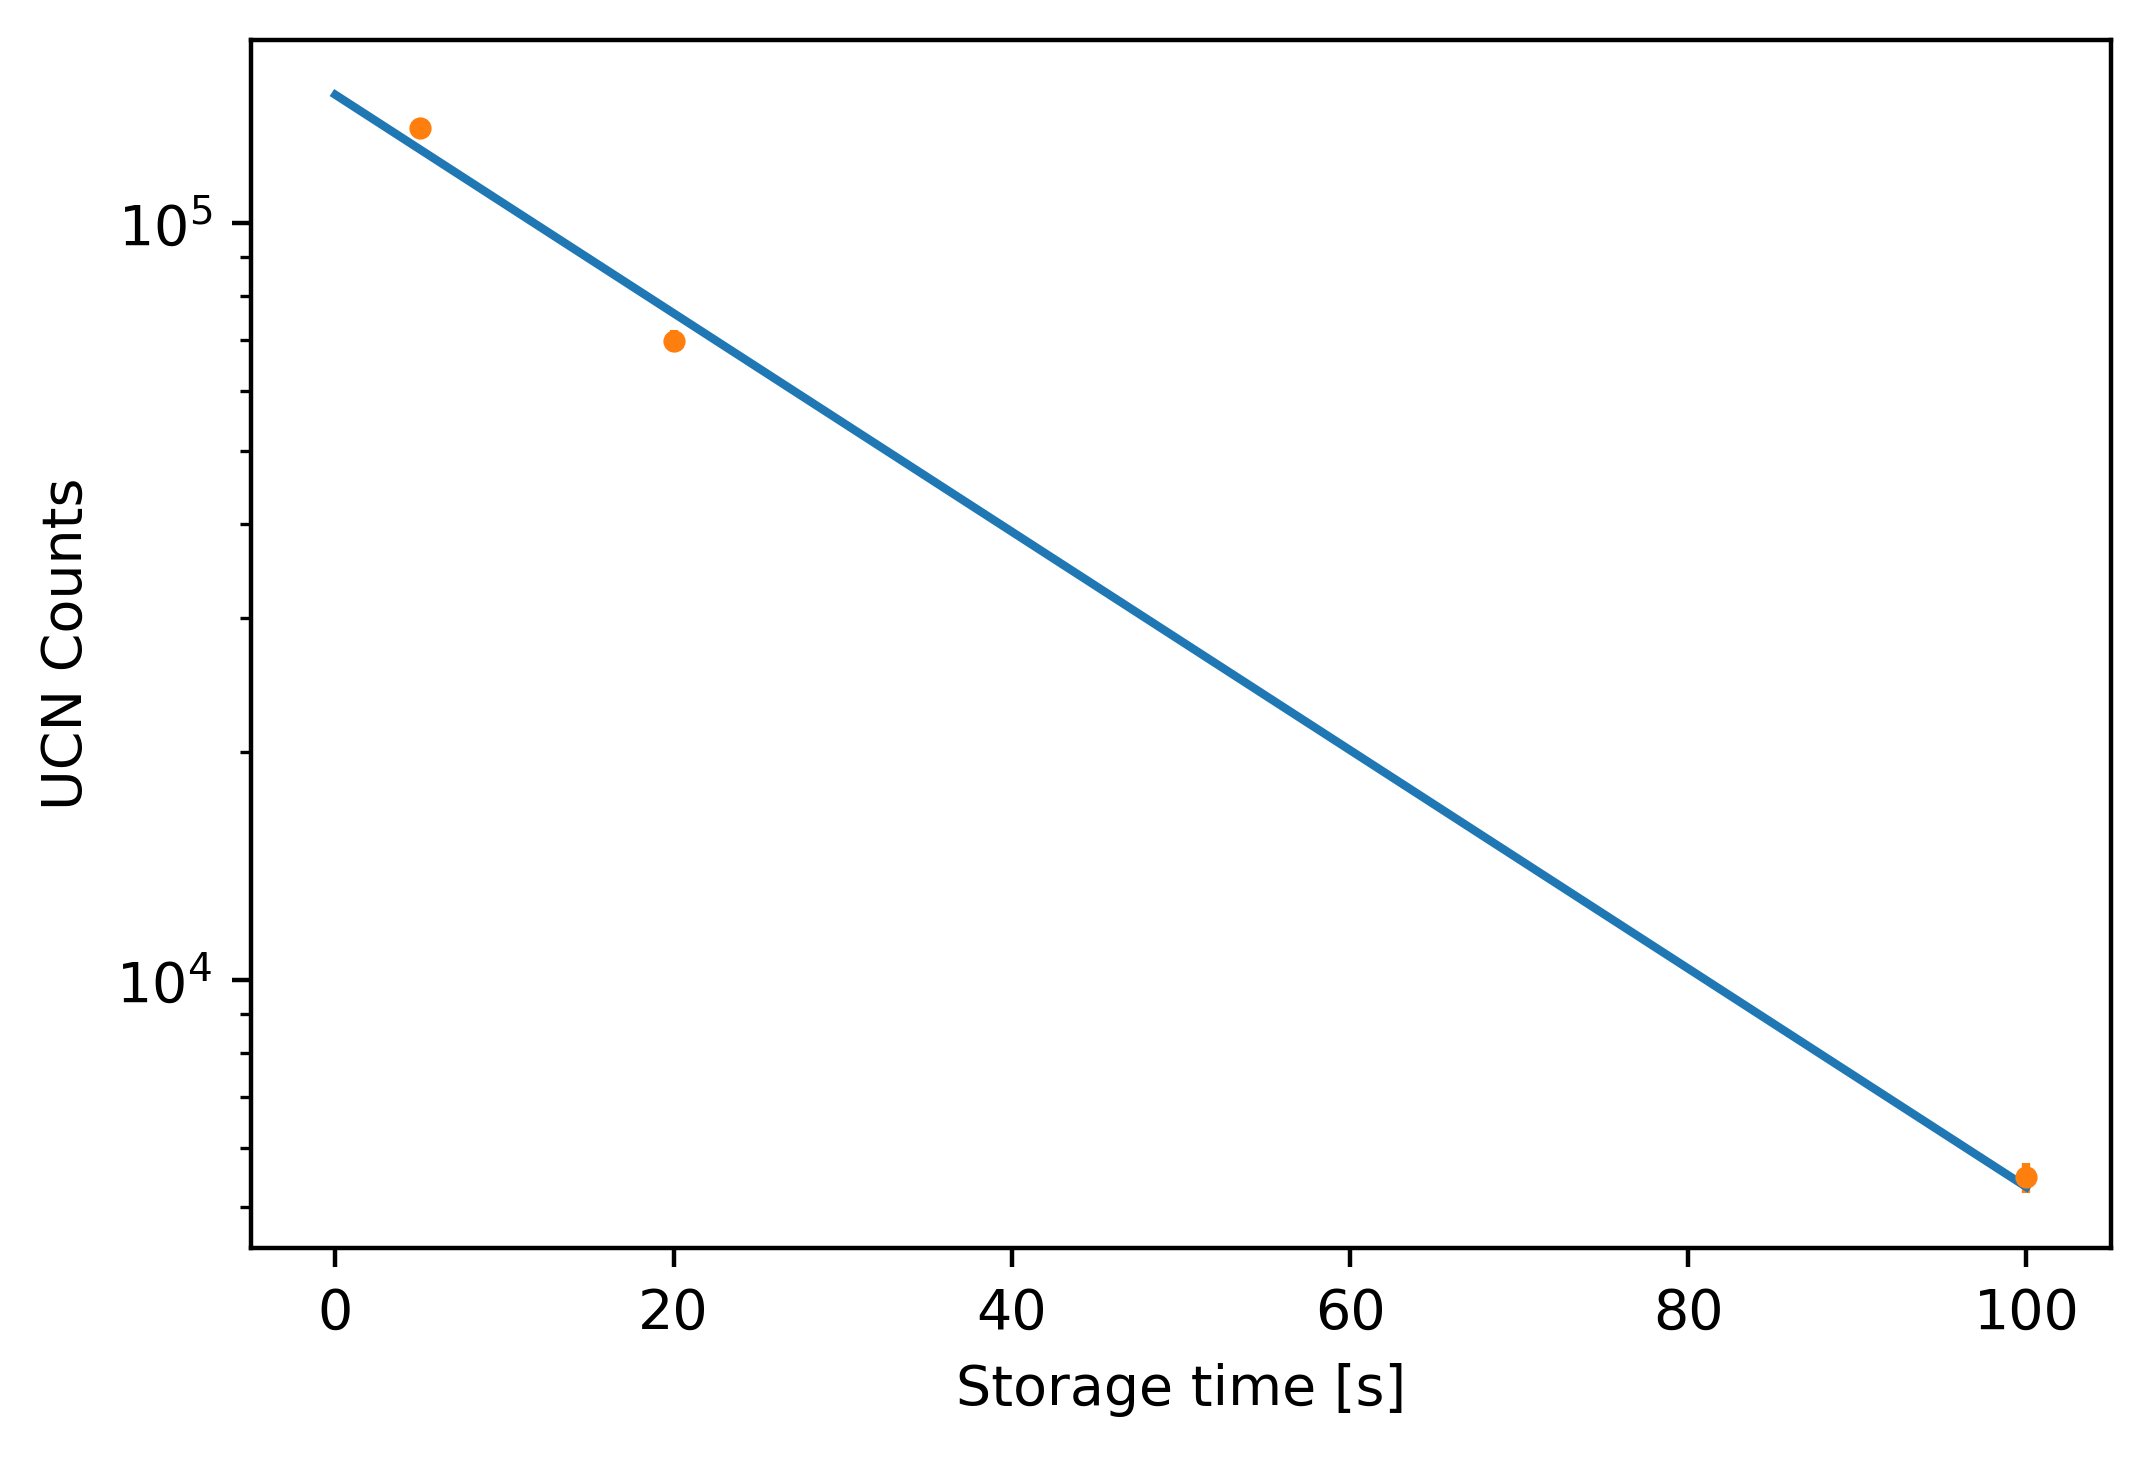

In [42]:
norm_storage_results = storage_lifetime(norm_data_list)

$$\huge{N = N_0 e^{\frac{-t}{\tau}}}$$

The very large $\chi^2 / \text{dof}$ is hopefully just an artifact of the source normalization. The normalization of all points to the decay of the source demonstrated that there are systematics present that have not been accounted for. The small error bar on the data points presented here, relative to the spread of the points, is hopefully an additional reflection of this fact.

## JP SUS with NiP Guide

Relevant runs:

Run #'s                      | Day |  Storage Time (s)   | Configuration          |
---                          | --- |      ---            | ---                    |
 50 - 60                     | 8   |      100            | JP SUS guide with NiP  |
 61 - 63                     | 8   |        5            | JP SUS guide with NiP  |
 64 - 66*                    | 8   |       20            | JP SUS guide with NiP  |
 
 


In [43]:
# load data for different storage times
jpsu_data_5    = load_data_2('JPSU', 's005', normalize_flag = True)
jpsu_data_20   = load_data_2('JPSU', 's020', normalize_flag = True)
jpsu_data_100  = load_data_2('JPSU', 's100', normalize_flag = True)
jpsu_data_list = [jpsu_data_5, jpsu_data_20, jpsu_data_100]

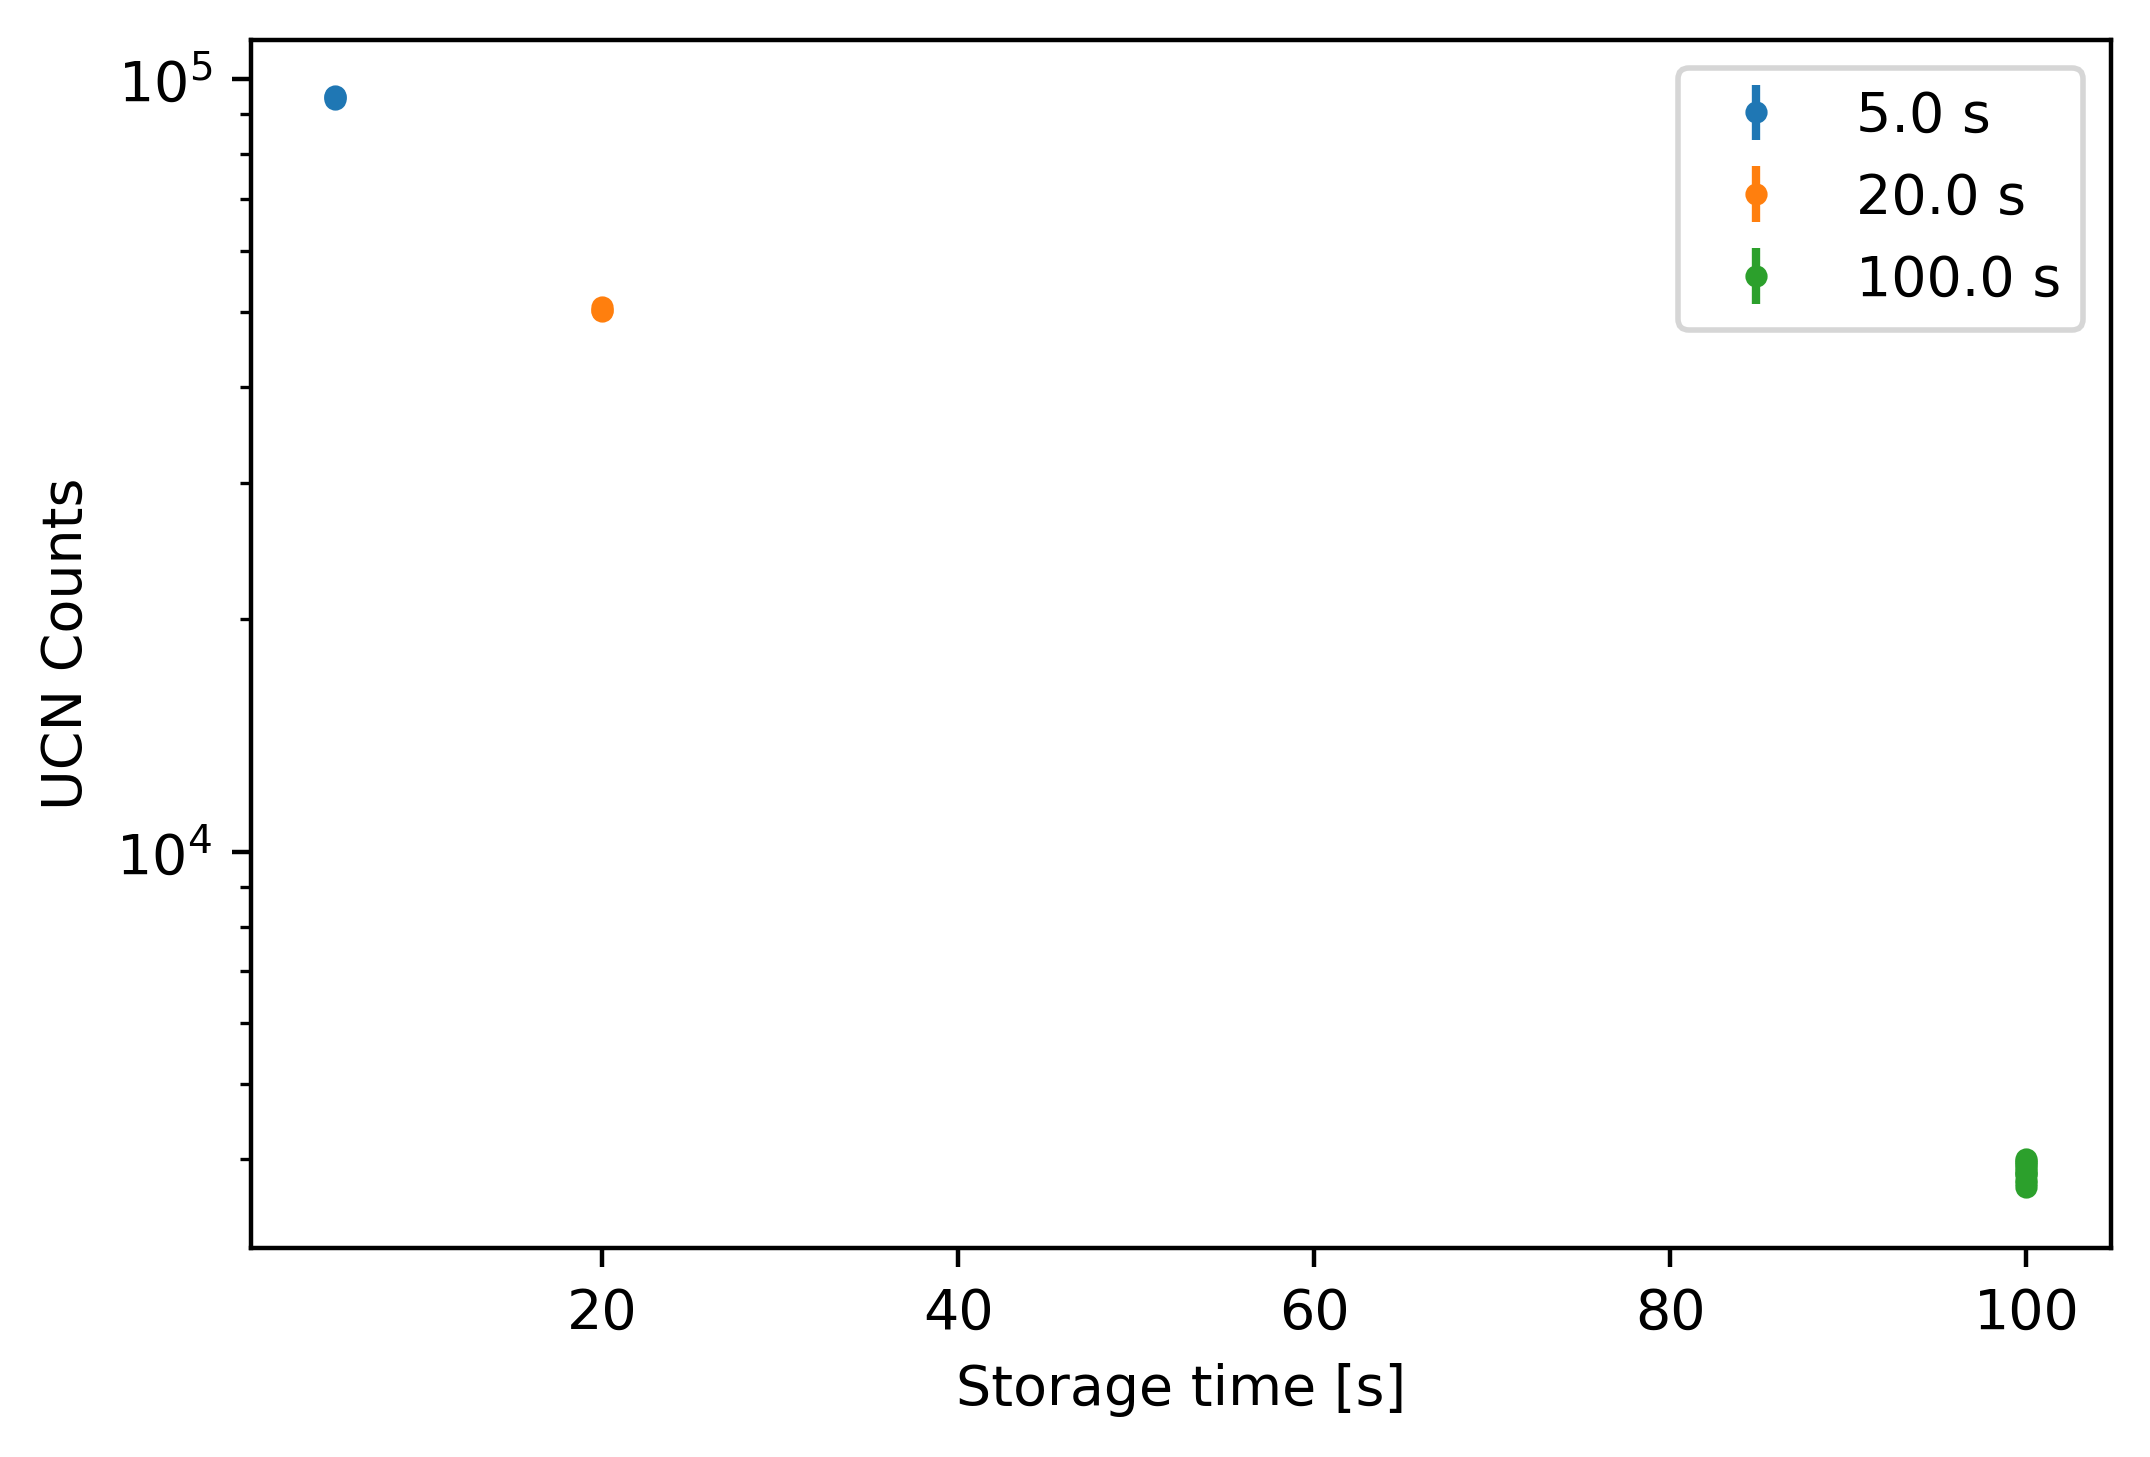

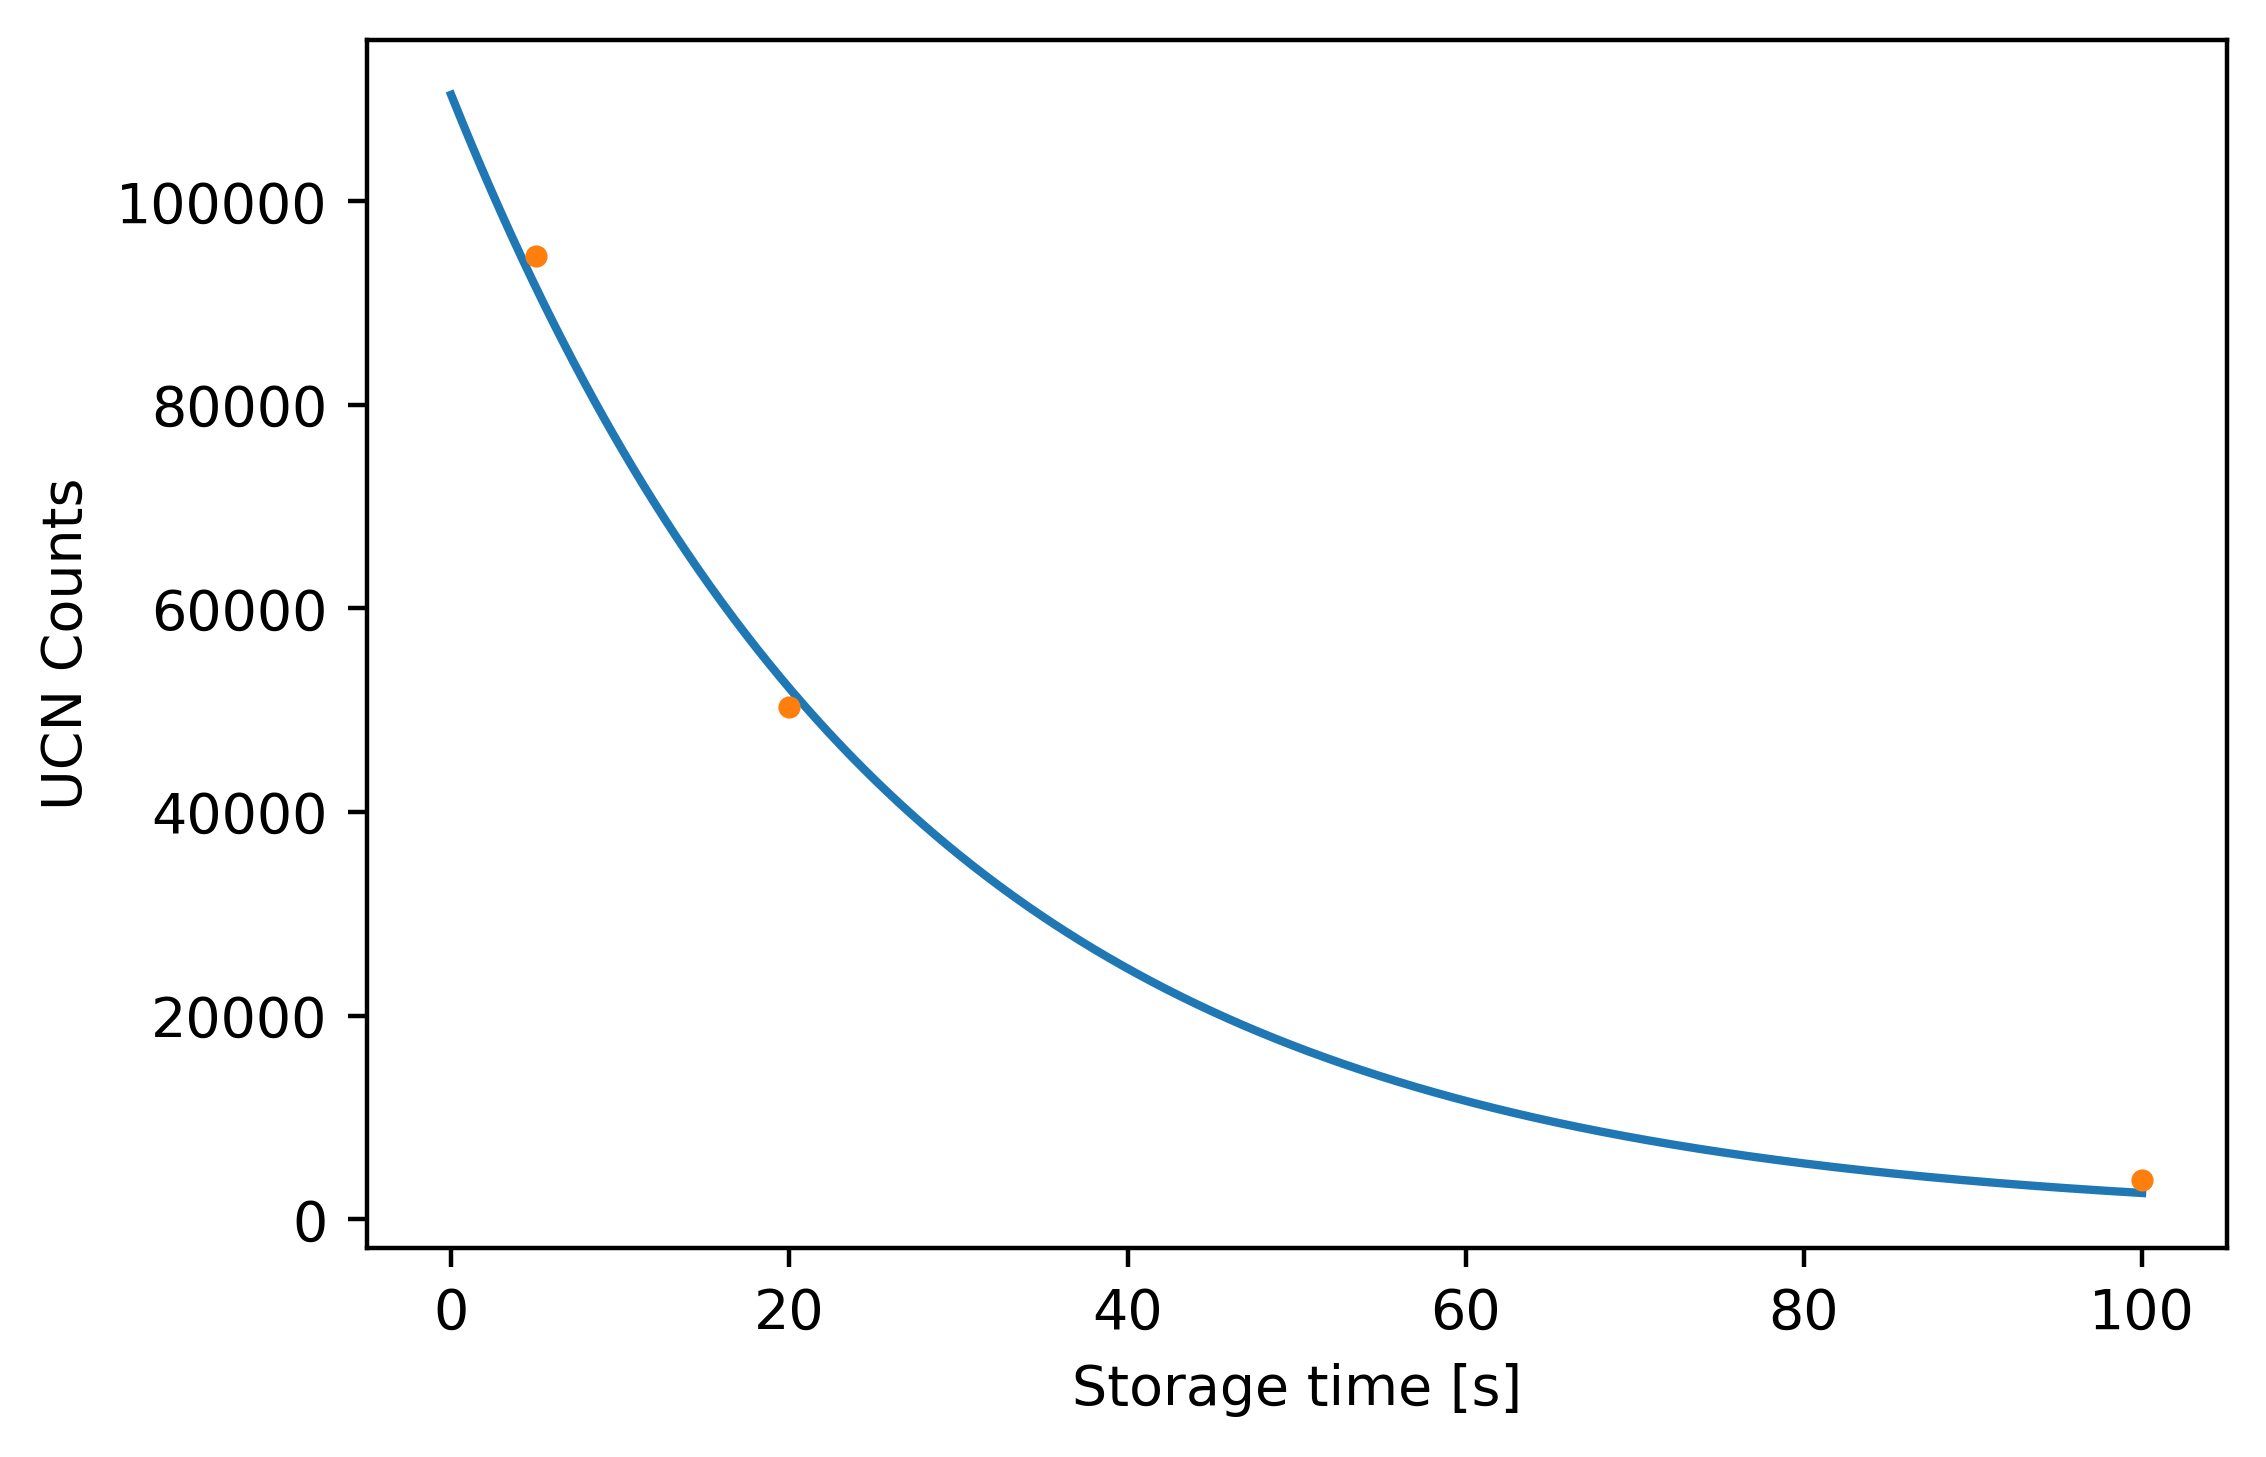

Fit parameters:
 N_0 = 110450.50092894449 +/- 560.5045476248446,
 TAU: 26.667813627306128 +/- 0.21394005394301088
chi_sq / dof = 283.55431218052746


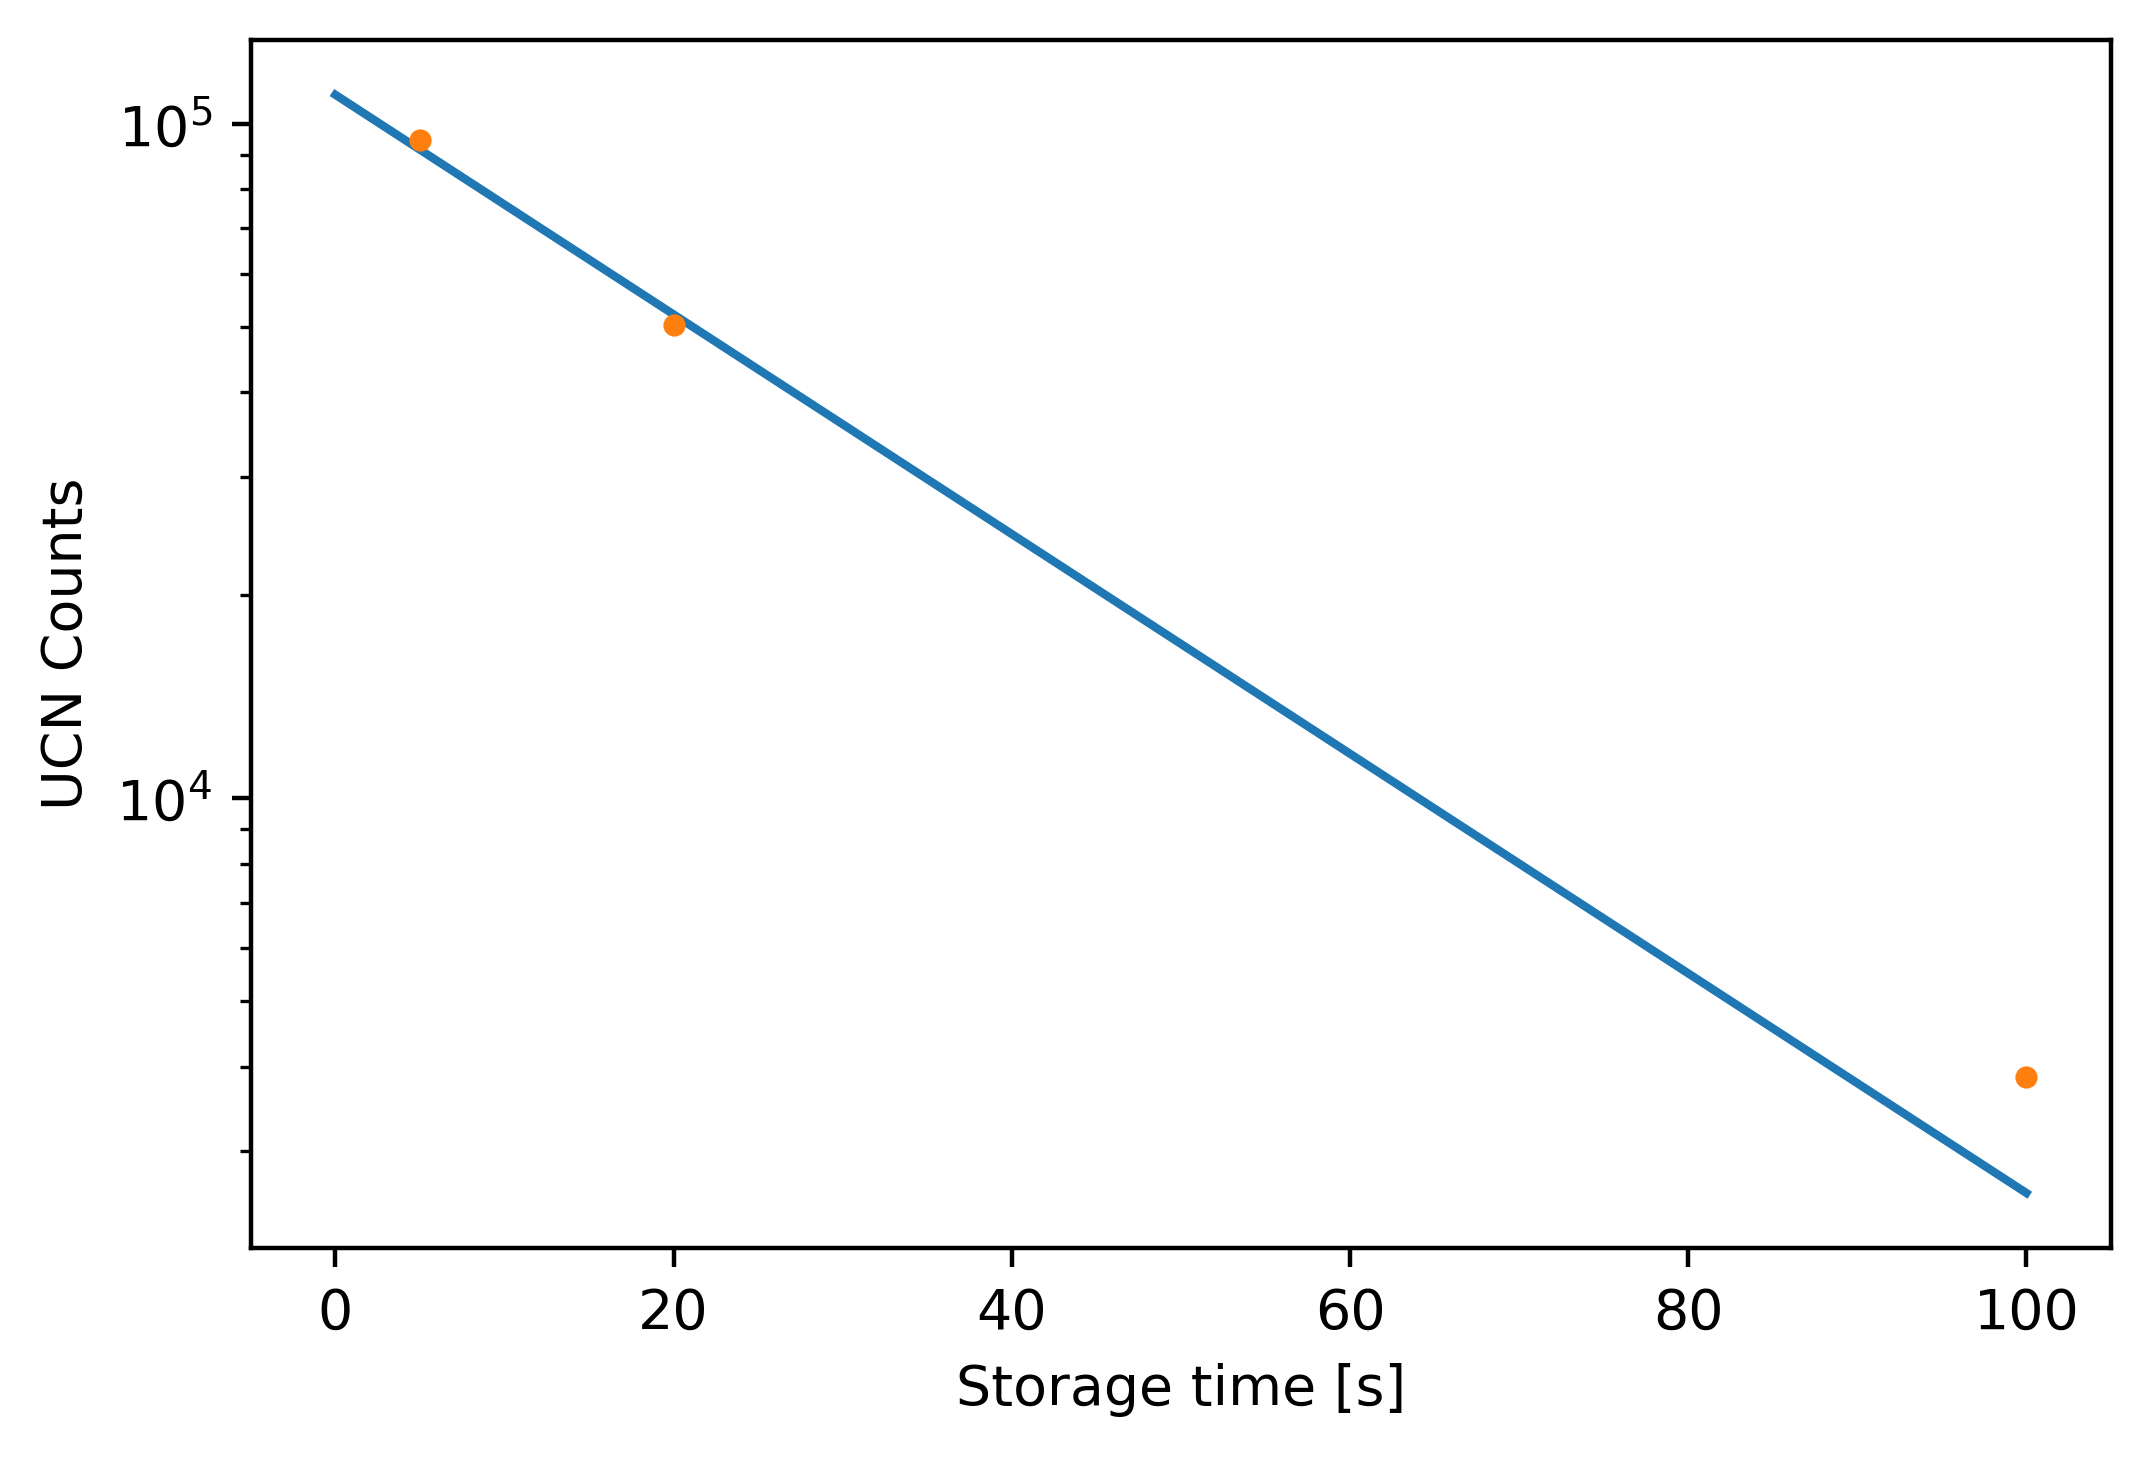

In [44]:
jpsu_storage_results = storage_lifetime(jpsu_data_list)

## JP Ti with NiP Guide

Relevant Runs:

Run #'s                      | Day |  Storage Time (s)   | Configuration          |
---                          | --- |      ---            | ---                    |
 99 - 105                    | 8   |      100            | JP Ti guide with NiP   |
  1 - 90                     | 9   |      100            | JP Ti guide with NiP   |
 99 - 101                    | 9   |       20            | JP Ti guide with NiP   |
102 - 110                    | 9   |        5            | JP Ti guide with NiP   |

In [45]:
# load data for different storage times
jpti_data_5    = load_data_2('JPTI', 's005', normalize_flag = True)
jpti_data_20   = load_data_2('JPTI', 's020', normalize_flag = True)
jpti_data_100  = load_data_2('JPTI', 's100', normalize_flag = True)
jpti_data_list = [jpti_data_5, jpti_data_20, jpti_data_100]

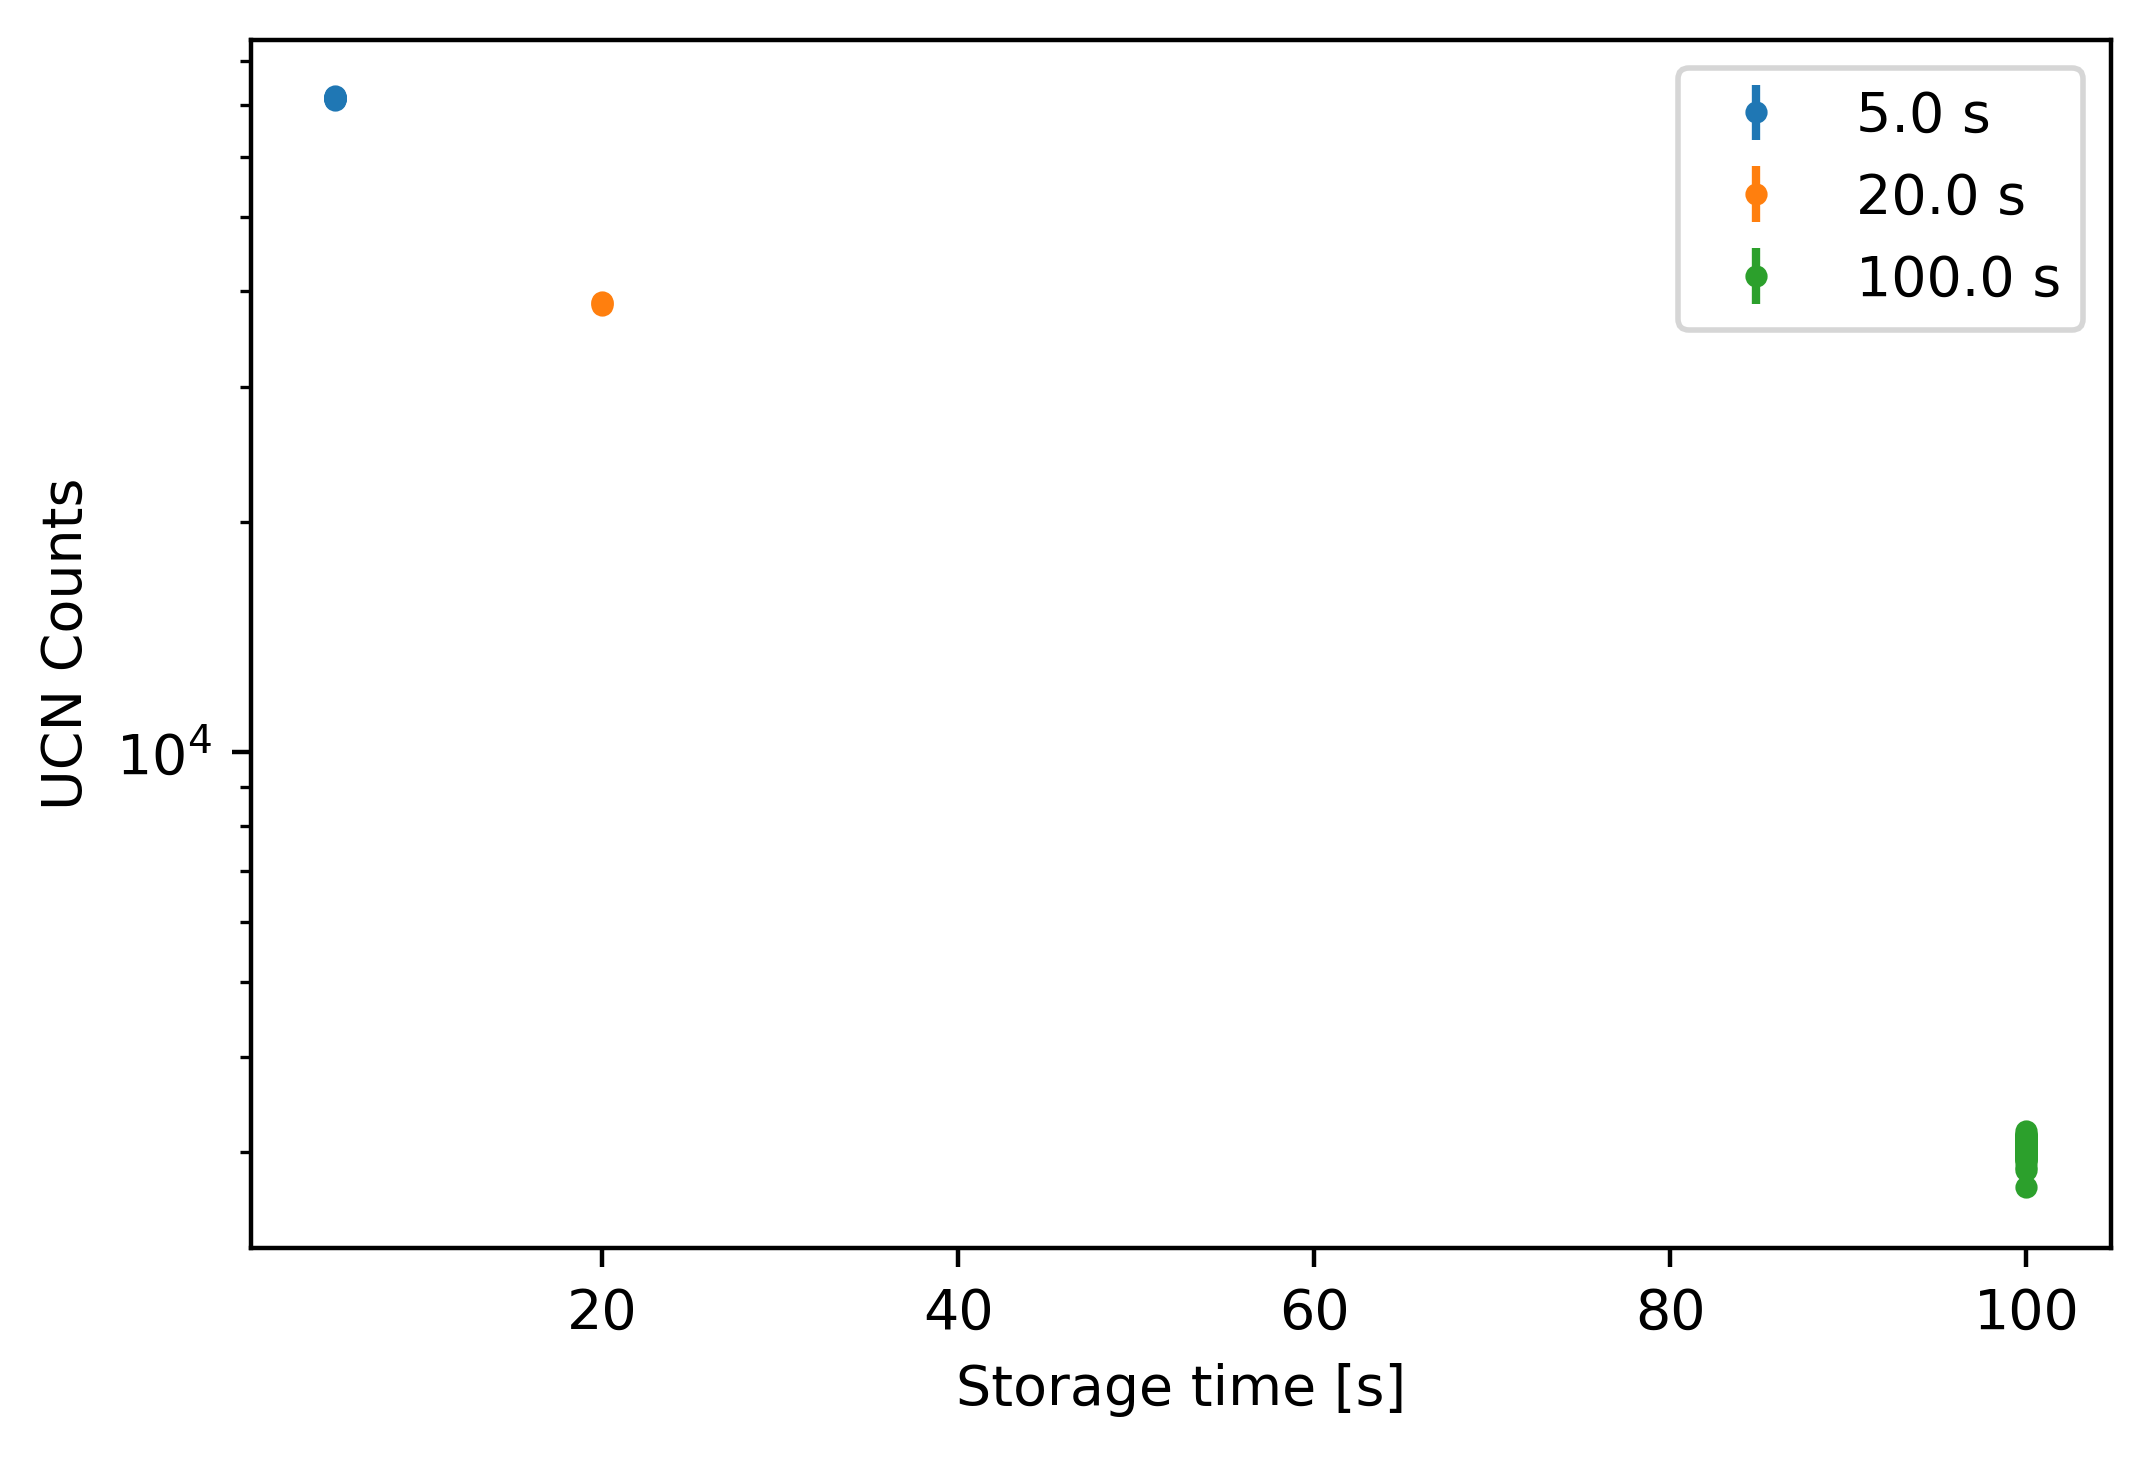

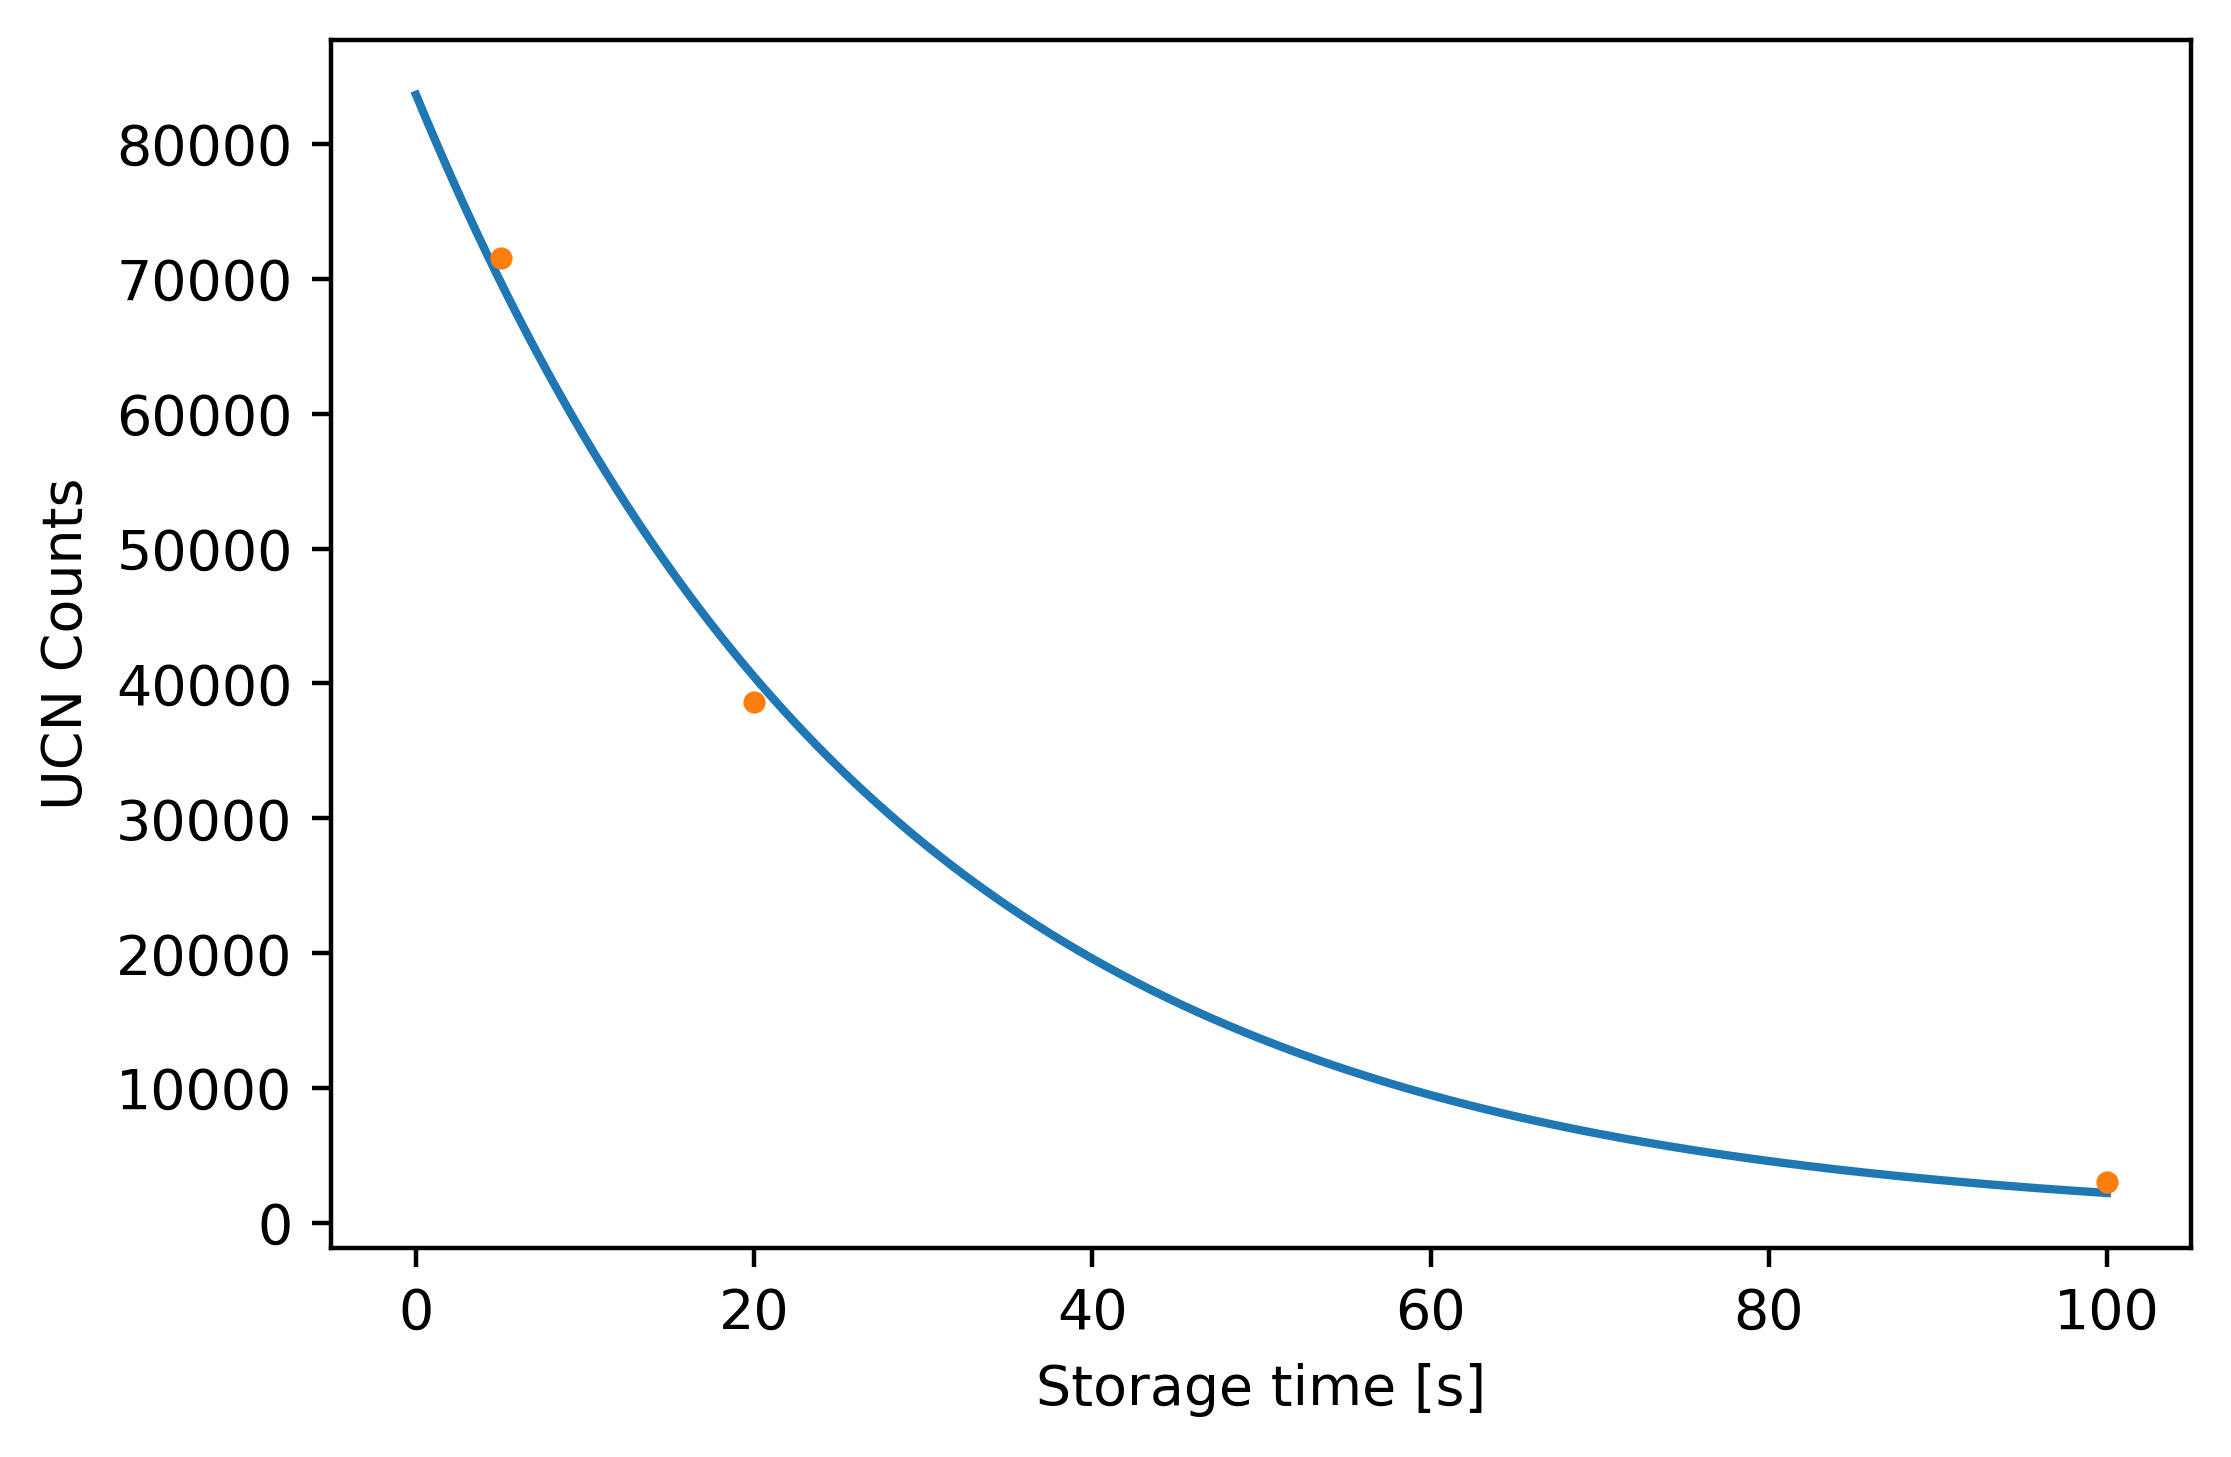

Fit parameters:
 N_0 = 83645.6718776858 +/- 349.26002227753804,
 TAU: 27.56195672973539 +/- 0.20044189765203352
chi_sq / dof = 286.8648070752635


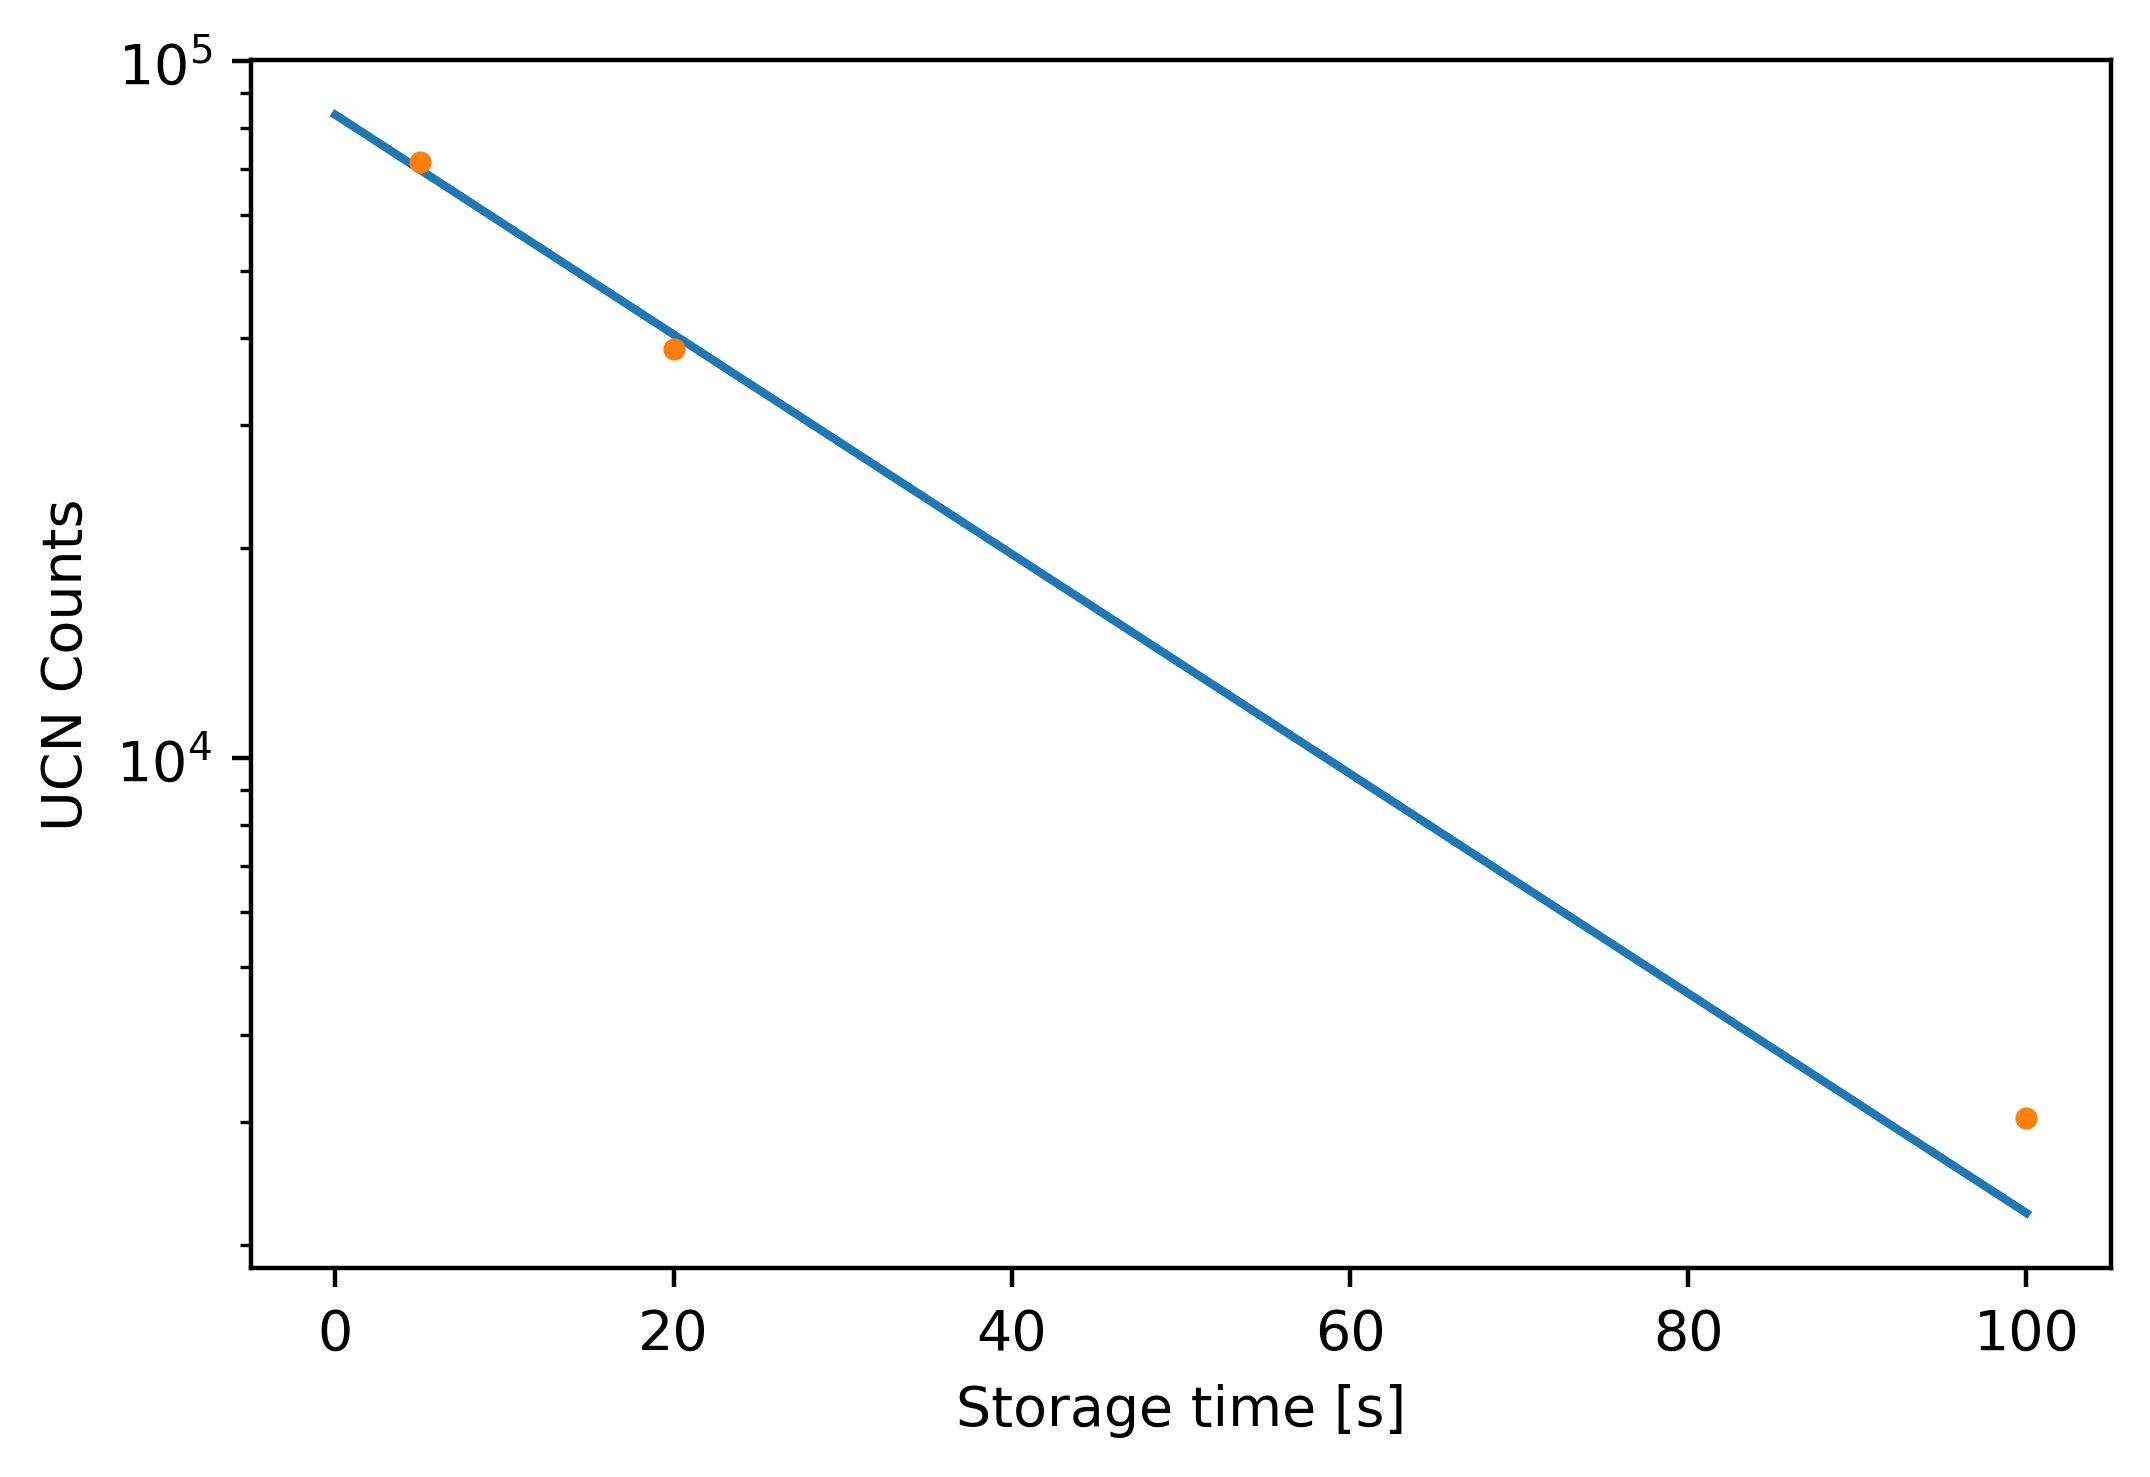

In [46]:
jpti_storage_results = storage_lifetime(jpti_data_list)

## SS Disk

Relevant Runs:

Run #'s                      | Day |  Storage Time (s)   | Configuration          |
---                          | --- |      ---            | ---                    |
146 - 153                    | 9   |      100            | SS disk                |
154 - 156                    | 9   |       20            | SS disk                |
157 - 159                    | 9   |        5            | SS disk                |

(!!! Have not yet confirmed the purpose of this configuration)

In [47]:
# load data for different storage times
disk_data_5    = load_data_2('DISK', 's005', normalize_flag = True)
disk_data_20   = load_data_2('DISK', 's020', normalize_flag = True)
disk_data_100  = load_data_2('DISK', 's100', normalize_flag = True)
disk_data_list = [disk_data_5, disk_data_20, disk_data_100]

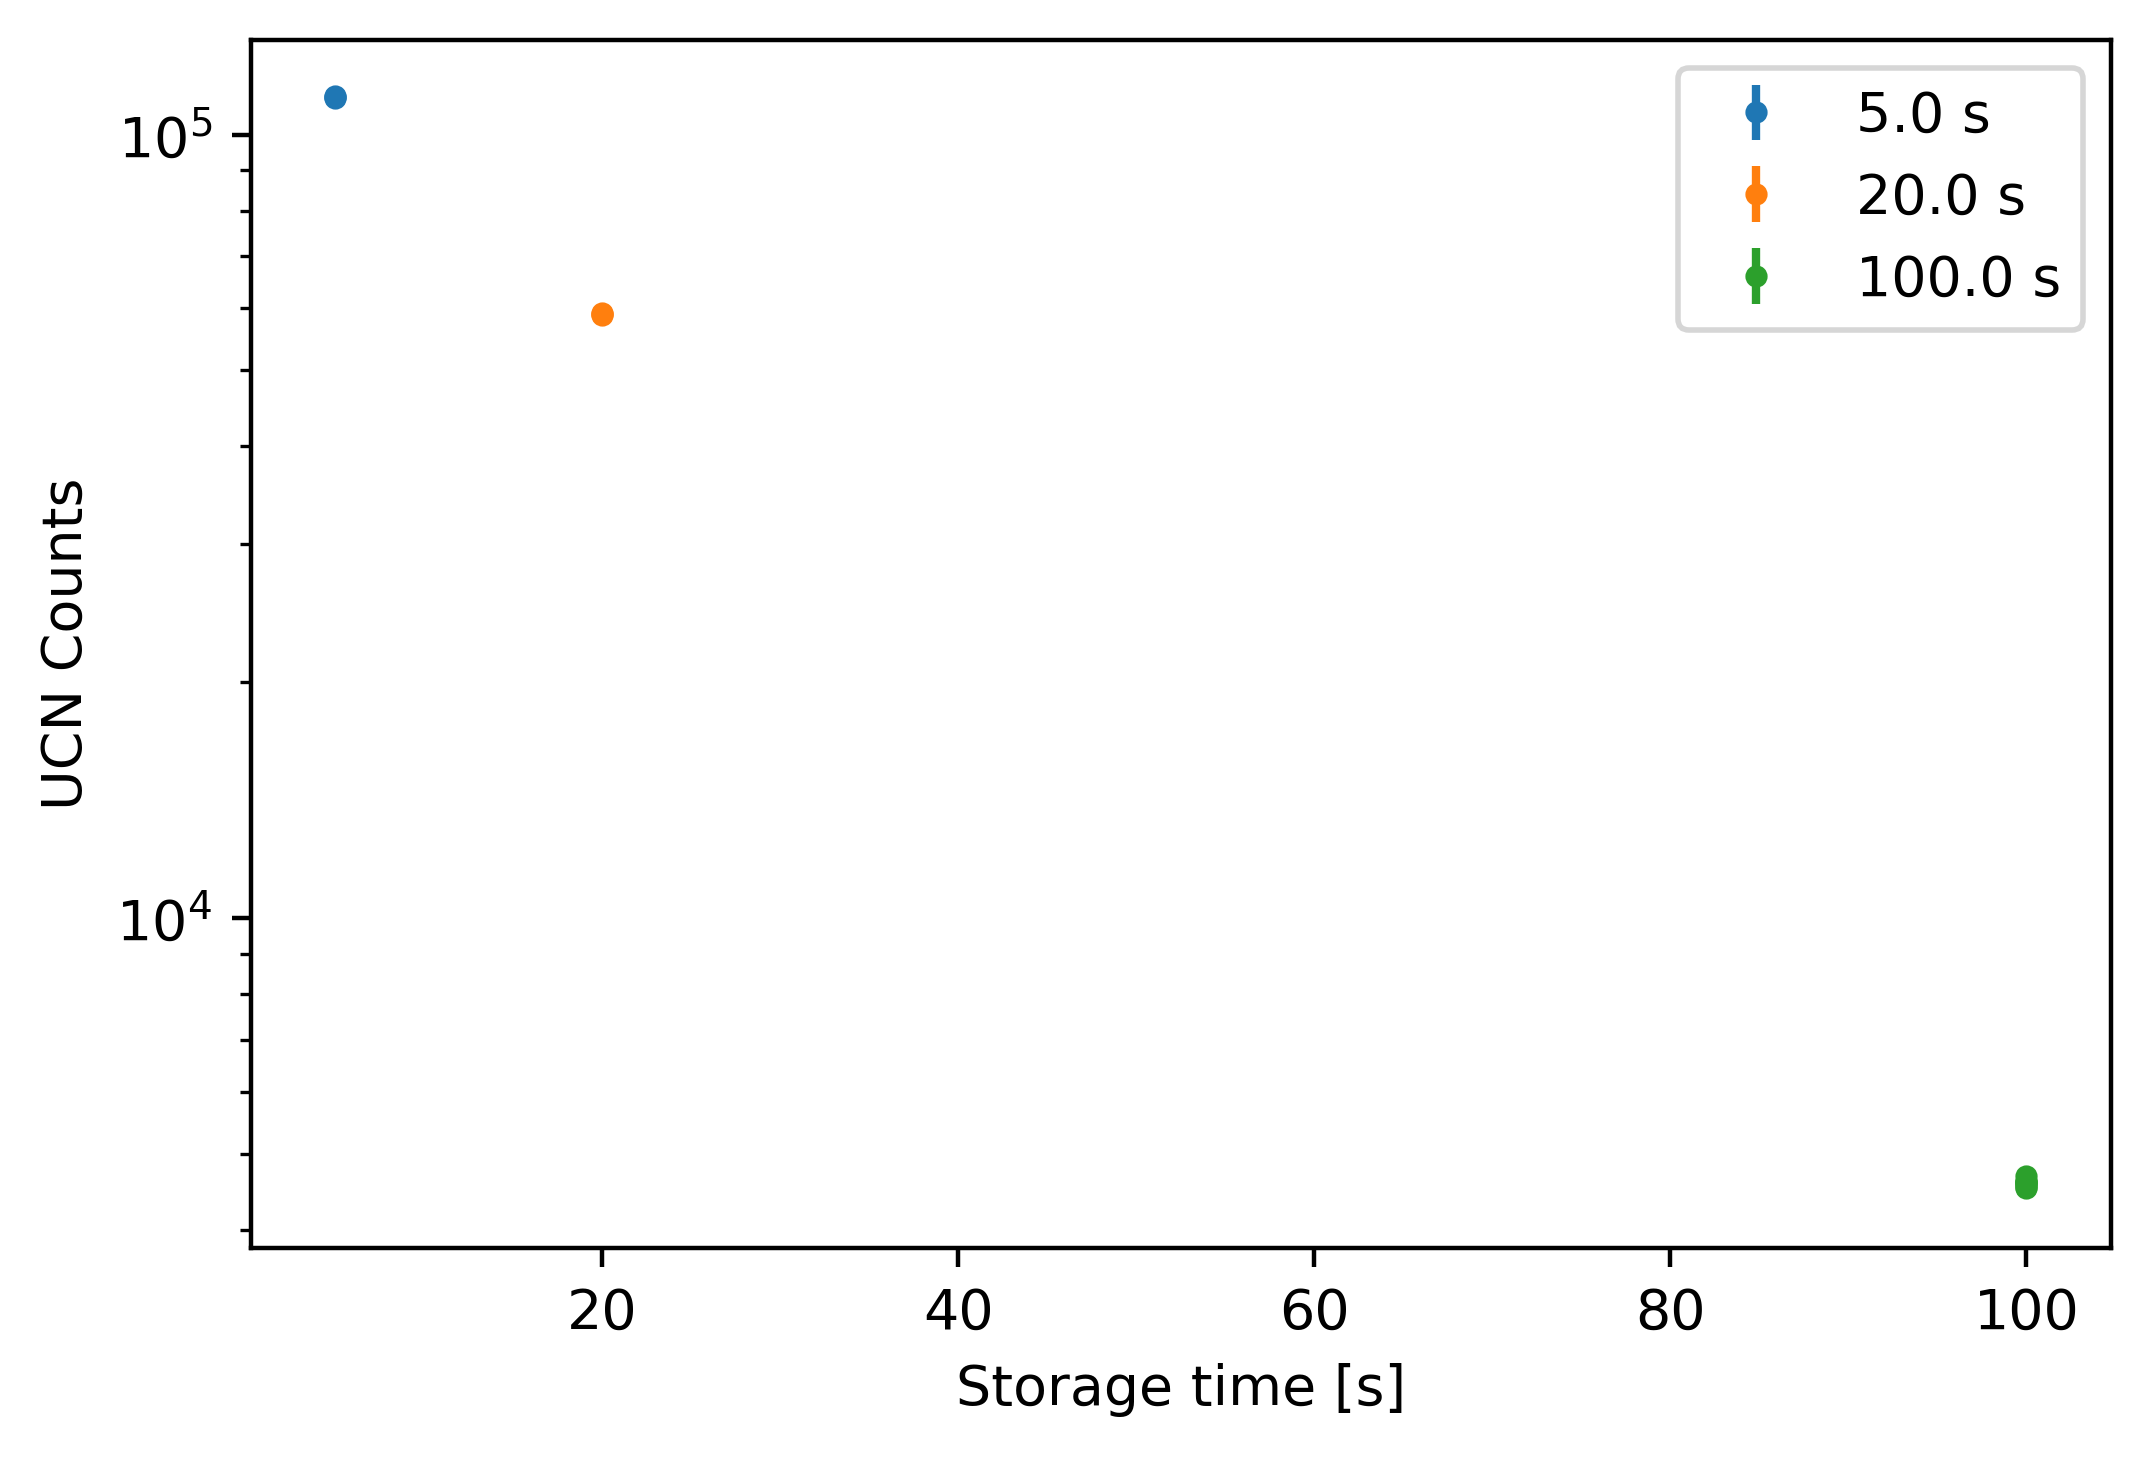

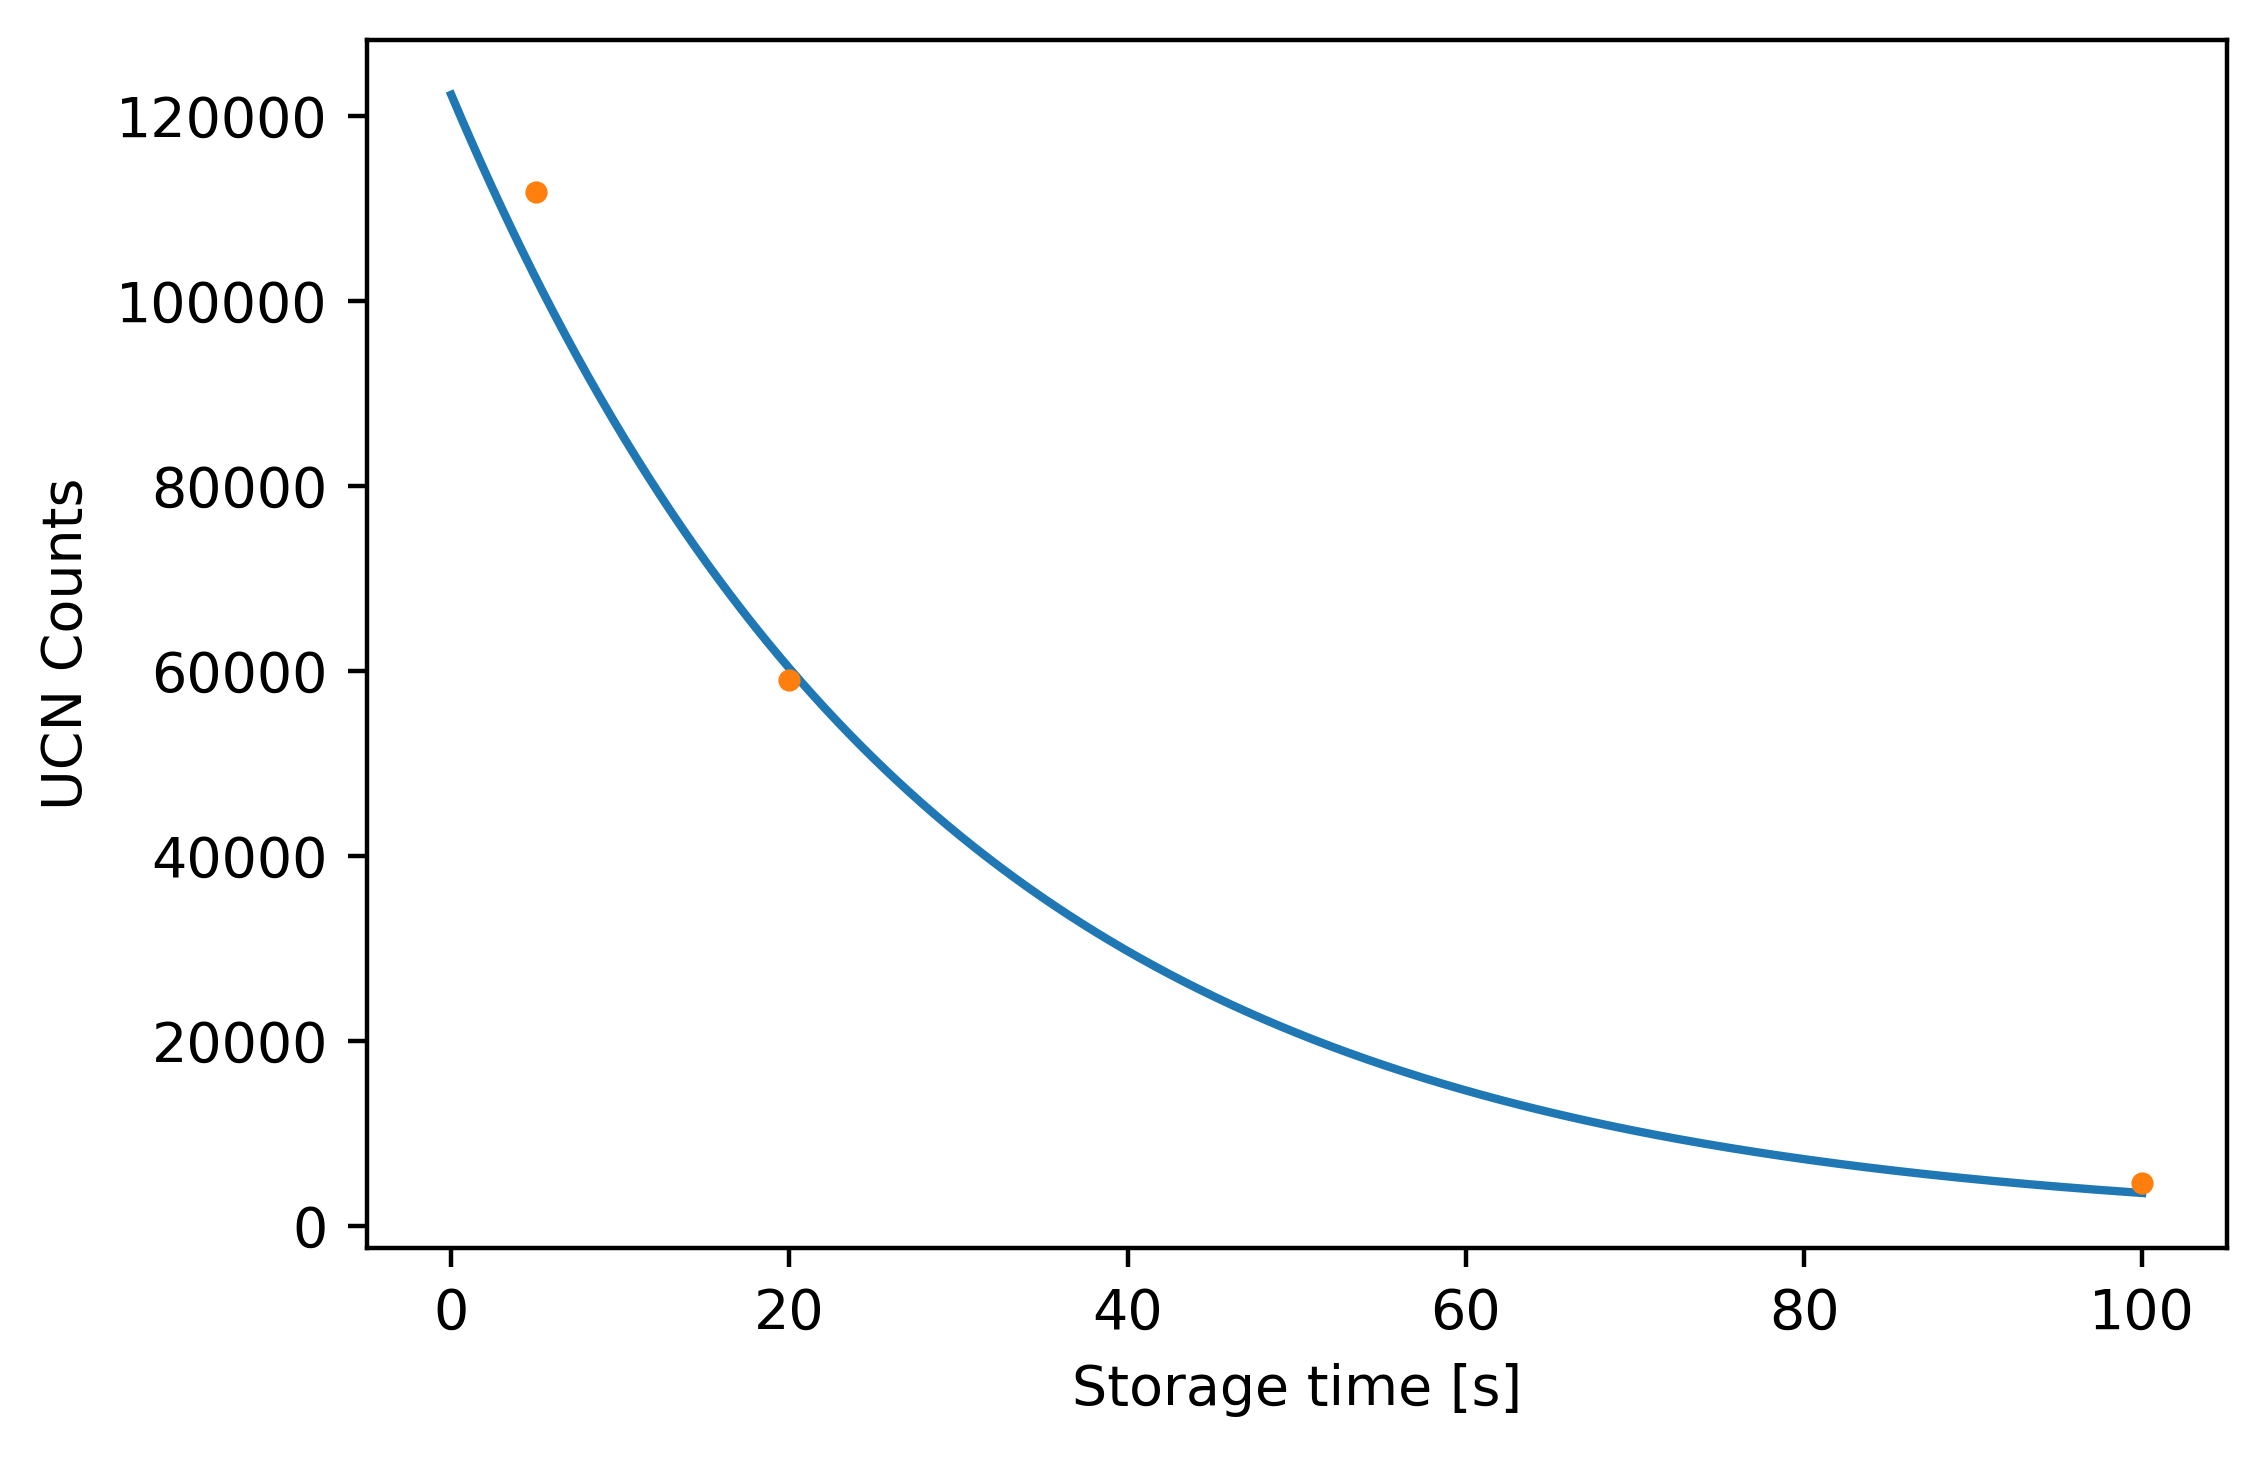

Fit parameters:
 N_0 = 122241.7881500537 +/- 350.70398701873336,
 TAU: 28.267000362066188 +/- 0.11070706257159356
chi_sq / dof = 1376.1885618589517


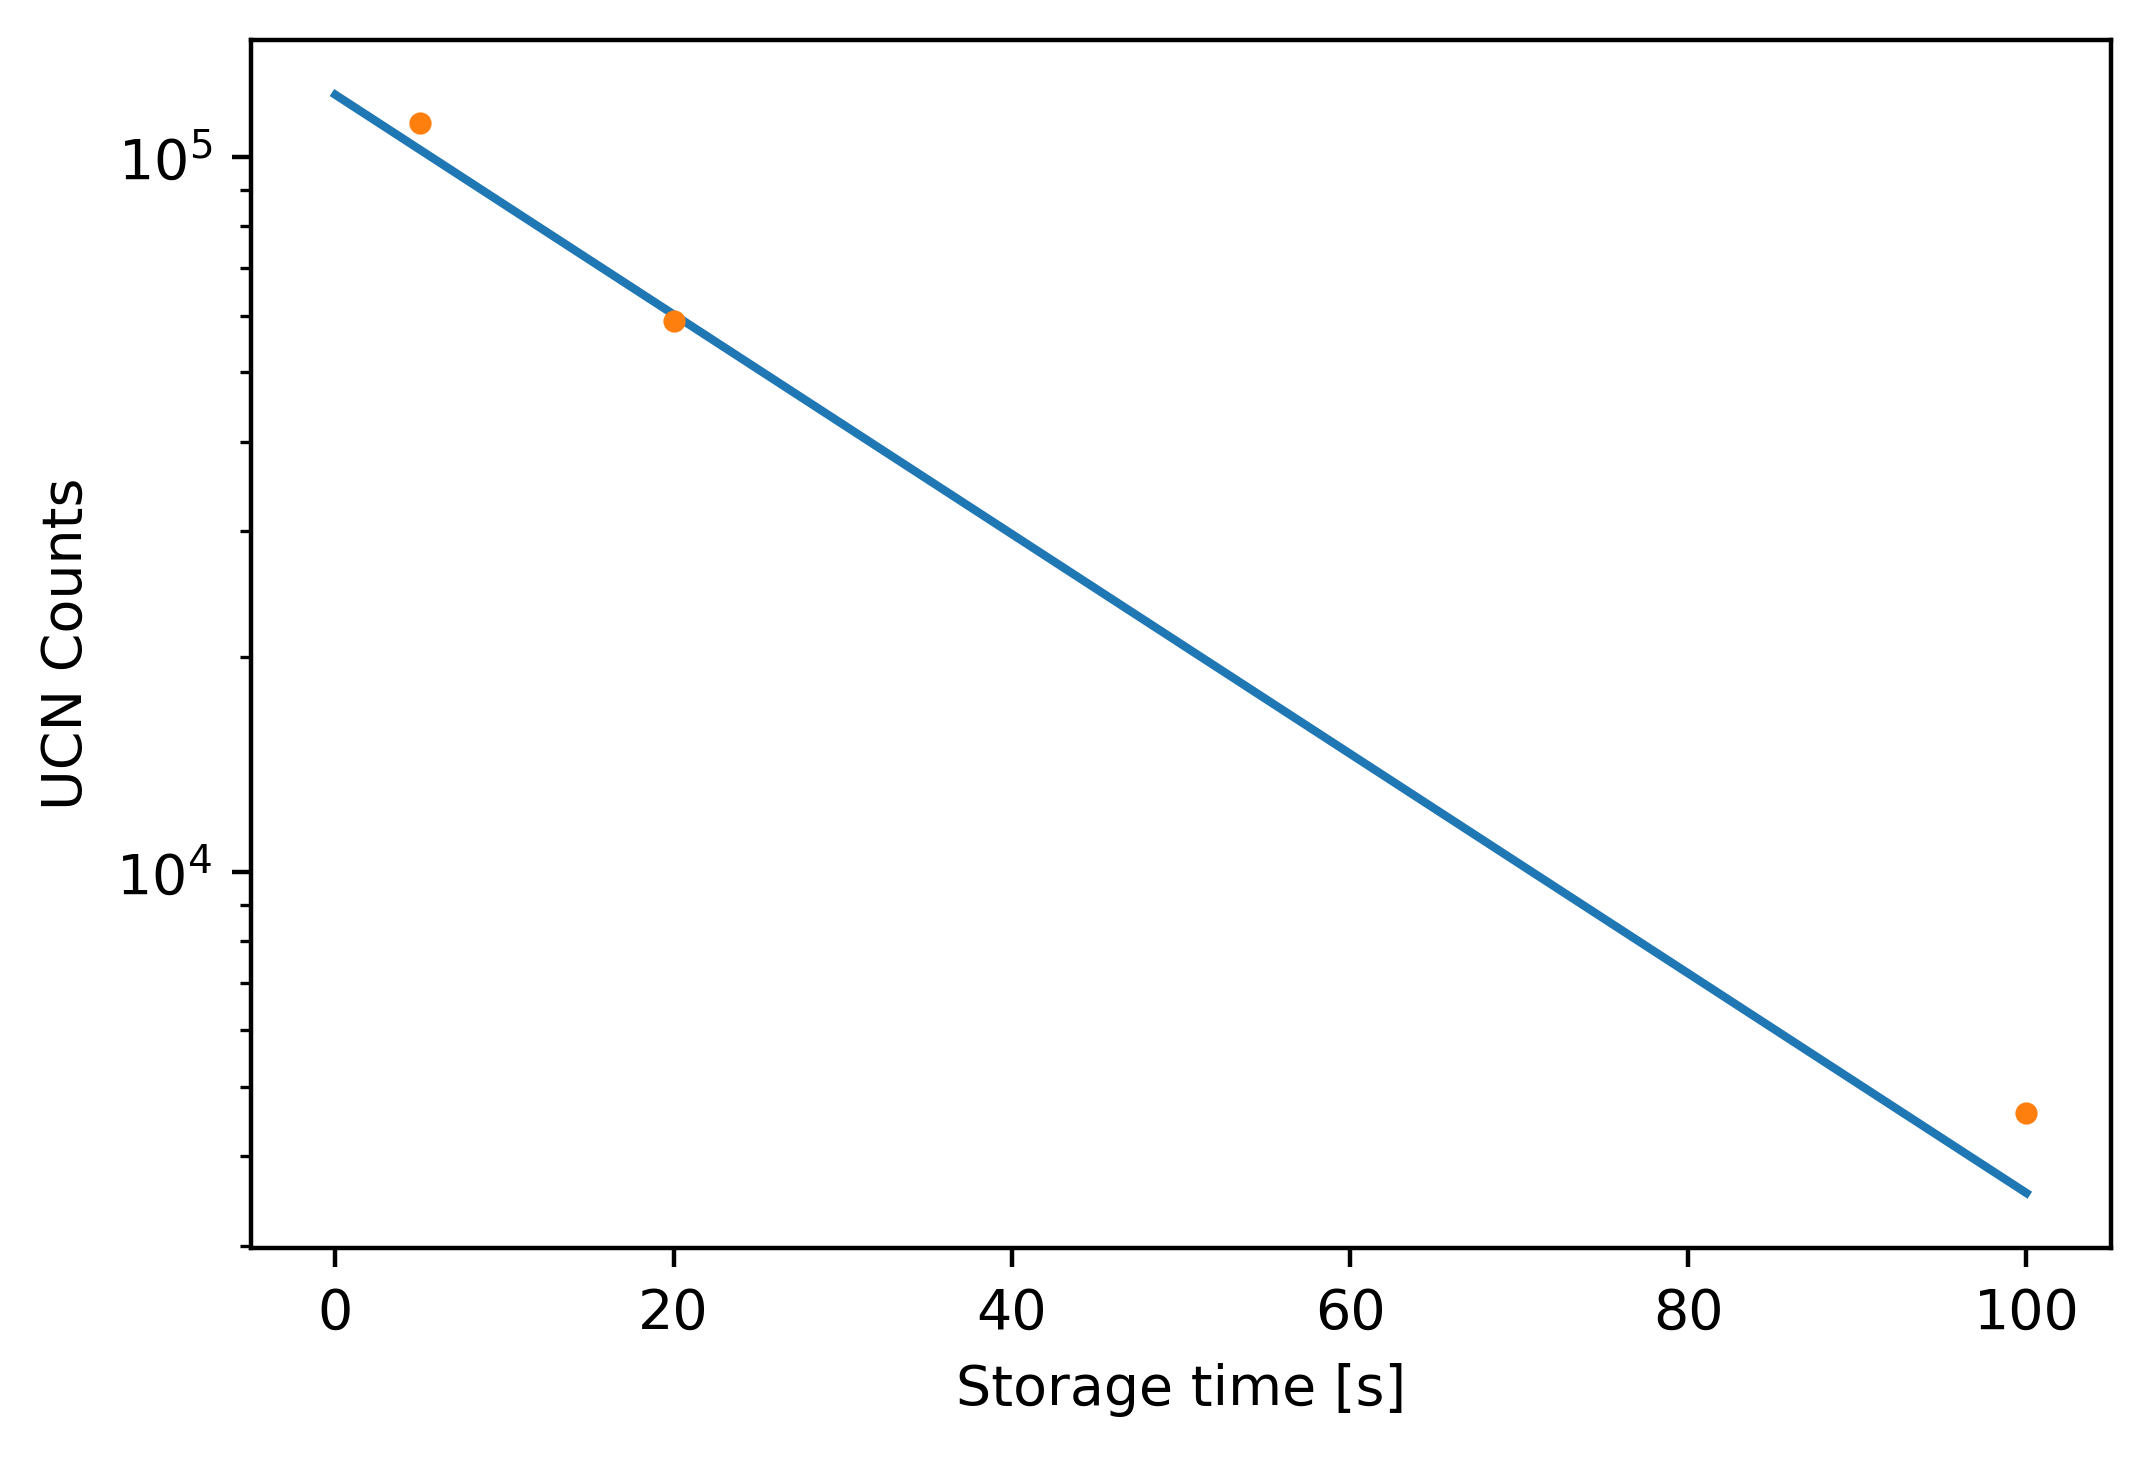

In [48]:
disk_storage_results = storage_lifetime(disk_data_list)

## UDG01

Relevant Runs:

Run #'s                      | Day |  Storage Time (s)   | Configuration          |
---                          | --- |      ---            | ---                    |
      199                    | 9   |      100            | UGD01                  |
  1 - 107                    | 10  |      100            | UGD01                  |
108 - 110                    | 10  |       20            | UGD01                  |
111 - 113                    | 10  |        5            | UGD01                  |

In [ ]:
# load data for different storage times
gd01_data_5    = load_data_2('GD01', 's005', normalize_flag = True)
gd01_data_20   = load_data_2('GD01', 's020', normalize_flag = True)
gd01_data_100  = load_data_2('GD01', 's100', normalize_flag = True)
gd01_data_list = [gd01_data_5, gd01_data_20, gd01_data_100]
    
gd01_storage_results = storage_lifetime(gd01_data_list)

## UDG03

Relevant Runs:

Run #'s                      | Day |  Storage Time (s)   | Configuration          |
---                          | --- |      ---            | ---                    |
146 - 155                    | 10  |      100            | UGD03                  |
156 - 158                    | 10  |       20            | UGD03                  |
159 - 161                    | 10  |        5            | UGD03                  |

In [ ]:
# load data for different storage times
gd03_data_5    = load_data_2('GD03', 's005', normalize_flag = True)
gd03_data_20   = load_data_2('GD03', 's020', normalize_flag = True)
gd03_data_100  = load_data_2('GD03', 's100', normalize_flag = True)
gd03_data_list = [gd03_data_5, gd03_data_20, gd03_data_100]
    
gd03_storage_results = storage_lifetime(gd03_data_list)

## EP SUS guide with NiP

Relevant Runs:

Run #'s                      | Day |  Storage Time (s)   | Configuration          |
---                          | --- |      ---            | ---                    |
      195                    | 10  |      100            | EP SUS guide with NiP  |
196 - 198                    | 10  |        5            | EP SUS guide with NiP  |
199 - 201                    | 10  |       20            | EP SUS guide with NiP  |
202 - 241                    | 10  |      100            | EP SUS guide with NiP  |

In [ ]:
# load data for different storage times
epsu_data_5    = load_data_2('EPSU', 's005', normalize_flag = True)
epsu_data_20   = load_data_2('EPSU', 's020', normalize_flag = True)
epsu_data_100  = load_data_2('EPSU', 's100', normalize_flag = True)
epsu_data_list = [epsu_data_5, epsu_data_20, epsu_data_100]
    
epsu_storage_results = storage_lifetime(epsu_data_list)

## Questions:

- Does it make sense to use every data point (multiple guide configurations) within a single fit for storage lifetime?
- Why are the 100 second storage times seemingly off the fit? 